In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import squidpy as sq
import matplotlib.image as mpimg
import os
import json
from pathlib import Path
from scipy.sparse import issparse, csr_matrix 
import matplotlib.pyplot as plt
import cell2location
from cell2location.models import RegressionModel, Cell2location

/auto/vestec1-elixir/home/bucekl/labgenexp/spatial_project/venv/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/auto/vestec1-elixir/home/bucekl/labgenexp/spatial_project/venv/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/auto/vestec1-elixir/home/bucekl/labgenexp/spatial_project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path = Path("/storage/praha1/home/bucekl/labgenexp/spatial_project/spatial/data/10.1016:j.cell.2024.09.046/visium/outputs")
spatial_base = base_path / "split"
h5_file = base_path / "GSE252265_filtered_feature_bc_matrix.h5"
positions_csv = base_path / "GSE252265_aggr_tissue_positions.csv"
sc_adata_path = "/storage/praha1/home/bucekl/labgenexp/spatial_project/sc/data/GSE181919/processed_scRNA_annotated_data.h5ad"

In [3]:
# --- Directories for Saving ---
plot_save_dir = "./c2l_plots_v4/"
results_save_dir = "./c2l_results_v4/" 
os.makedirs(results_save_dir, exist_ok=True)
os.makedirs(plot_save_dir, exist_ok=True)
#st qc params
visium_min_counts = 500
visium_min_genes = 200
visium_max_mt_pct = 10

In [4]:
# Load full aggregated data
adata = sc.read_10x_h5(h5_file)
adata.var_names_make_unique()
print(f"Initial Visium data shape: {adata.shape}")

# Extract sample IDs from barcode suffix (-1, -2, ..., -8)
adata.obs["sample_id"] = adata.obs_names.str.split("-").str[-1]

# Load spatial coordinates
positions = pd.read_csv(positions_csv, index_col=0)

# Subset positions to match available barcodes
positions = positions.loc[adata.obs_names]
adata.obs = pd.concat([adata.obs, positions], axis=1)

# Create spatial coordinate array
adata.obsm["spatial"] = adata.obs[["pxl_col_in_fullres", "pxl_row_in_fullres"]].values

# Initialize spatial image dict
adata.uns["spatial"] = {}

# Add images & scalefactors for each sample
for sid in adata.obs["sample_id"].unique():
    sid_str = str(sid)
    spatial_path = spatial_base / sid_str / "outs" / "spatial"

    # Load image
    image_path = spatial_path / "tissue_hires_image.png"
    image = mpimg.imread(image_path)

    # Load scalefactors
    with open(spatial_path / "scalefactors_json.json") as f:
        scalefactors = json.load(f)

    # Assign under correct key
    adata.uns["spatial"][sid_str] = {
        "images": {"hires": image},
        "scalefactors": scalefactors
    }

/auto/vestec1-elixir/home/bucekl/labgenexp/spatial_project/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/auto/vestec1-elixir/home/bucekl/labgenexp/spatial_project/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Initial Visium data shape: (11938, 36601)


In [5]:
# Mitochondrial genes
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")

# Compute QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=False)

n_spots_before = adata.n_obs
adata.obs['pass_basic_qc'] = (
    (adata.obs["total_counts"] >= visium_min_counts) &
    (adata.obs["n_genes_by_counts"] >= visium_min_genes) &
    (adata.obs["pct_counts_mt"] < visium_max_mt_pct)
)
adata_vis_qc = adata[adata.obs['pass_basic_qc']].copy()
n_spots_after = adata_vis_qc.n_obs
print(f"Filtered Visium spots. Before: {n_spots_before}, After: {n_spots_after}")

if n_spots_after == 0:
    raise ValueError("No spots remaining after QC filtering. Check QC parameters.")

# --- 6. Ensure Raw Counts Layer for Visium QC'd Data ---
print("Ensuring raw counts layer for QC'd Visium data...")
if 'counts' not in adata_vis_qc.layers:
    if not issparse(adata_vis_qc.X):
         adata_vis_qc.X = csr_matrix(adata_vis_qc.X)
    adata_vis_qc.layers['counts'] = adata_vis_qc.X.copy()
    print("Saved raw counts to adata_vis_qc.layers['counts']")
else:
     print("Layer 'counts' already exists in adata_vis_qc.")

Filtered Visium spots. Before: 11938, After: 11573
Ensuring raw counts layer for QC'd Visium data...
Saved raw counts to adata_vis_qc.layers['counts']


In [6]:
#deconvolution parameter
sc_annotation_key = 'refined_annotation' 

# Load full aggregated data
print(f"--- Loading Processed Single-Cell Data from: {sc_adata_path} ---")
try:
    adata_sc = sc.read_h5ad(sc_adata_path)
    print(f"Single-cell data loaded: {adata_sc.shape}")
    # Verify necessary components
    assert 'counts' in adata_sc.layers, "Raw counts missing in adata_sc.layers['counts']!"
    assert sc_annotation_key in adata_sc.obs, f"Annotation '{sc_annotation_key}' missing in adata_sc.obs!"
    print(f"Found annotation column '{sc_annotation_key}' and counts layer.")
except FileNotFoundError:
    print(f"ERROR: Single-cell AnnData file not found at {sc_adata_path}")
    raise
except Exception as e:
    print(f"ERROR: Failed to load single-cell AnnData: {e}")
    raise

--- Loading Processed Single-Cell Data from: /storage/praha1/home/bucekl/labgenexp/spatial_project/sc/GSE181919/processed_scRNA_annotated_data.h5ad ---
Single-cell data loaded: (54239, 20000)
Found annotation column 'refined_annotation' and counts layer.



--- Refining Annotations based on Leiden Clusters (leiden_integrated_res2.5) ---
Original annotations from: 'cell.type'
Updates will be applied for clusters: ['10', '17', '26']
Results will be stored in: 'refined_annotation'

Initialized 'refined_annotation' with values from 'cell.type'.
Adding new potential categories: {'Potential_RICs'}
Updated categories for 'refined_annotation': ['B_Plasma.cells', 'Dendritic.cells', 'Endothelial.cells', 'Epithelial.cells', 'Fibroblasts', 'Macrophages', 'Malignant.cells', 'Mast.cells', 'Myocytes', 'T.cells', 'Potential_RICs']
Initial value counts:
refined_annotation
T.cells              17869
Fibroblasts          12336
B_Plasma.cells        7437
Malignant.cells       5113
Macrophages           4895
Endothelial.cells     3437
Dendritic.cells       1593
Epithelial.cells       993
Myocytes               296
Mast.cells             270
Potential_RICs           0

Applying specified updates...
  Updating 176 cells in Leiden cluster '10' to 'Potential_RIC

/var/tmp/pbs.10878604.pbs-m1.metacentrum.cz/ipykernel_190669/1966389054.py:34: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata_sc.obs[new_annotation_key]):


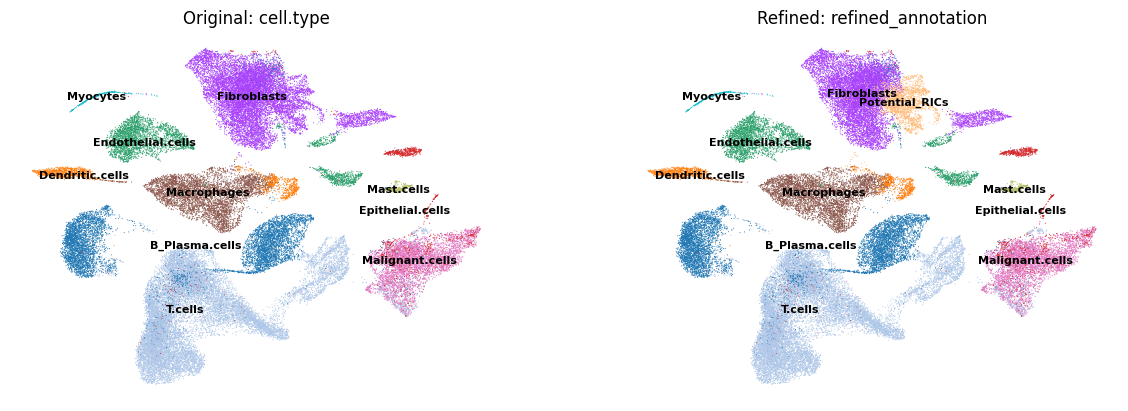


Comparison of original vs refined annotations (Crosstab):
refined_annotation  B_Plasma.cells  Dendritic.cells  Endothelial.cells  \
cell.type                                                                
B_Plasma.cells                7431                0                  0   
Dendritic.cells                  0             1593                  0   
Endothelial.cells                0                0               3437   
Epithelial.cells                 0                0                  0   
Fibroblasts                      0                0                  0   
Macrophages                      0                0                  0   
Malignant.cells                  0                0                  0   
Mast.cells                       0                0                  0   
Myocytes                         0                0                  0   
T.cells                          0                0                  0   

refined_annotation  Epithelial.cells  Fibroblasts  M

In [7]:
leiden_resolution_to_use = 2.5 # Change if you settled on a different resolution
leiden_key = f'leiden_integrated_res{leiden_resolution_to_use}' # e.g., 'leiden_1.5'
assert leiden_key in adata_sc.obs, "Leiden column missing!"


# 2. Specify the original annotation column
original_annotation_key = 'cell.type'

# 3. Specify the name for your new, refined annotation column
new_annotation_key = 'refined_annotation'

cluster_updates = {
    '10' : 'Potential_RICs',
    '17' : 'Potential_RICs',
    '26': 'Potential_RICs',
}

# --- Pre-computation Checks ---
# (Same as before)
if leiden_key not in adata_sc.obs.columns: raise KeyError(f"Leiden key '{leiden_key}' not found.")
if original_annotation_key not in adata_sc.obs.columns: raise KeyError(f"Original annotation key '{original_annotation_key}' not found.")

print(f"\n--- Refining Annotations based on Leiden Clusters ({leiden_key}) ---")
print(f"Original annotations from: '{original_annotation_key}'")
print(f"Updates will be applied for clusters: {list(cluster_updates.keys())}")
print(f"Results will be stored in: '{new_annotation_key}'")

# --- Create and Initialize New Annotation Column ---
if new_annotation_key in adata_sc.obs.columns:
     print(f"Warning: Column '{new_annotation_key}' already exists. It will be overwritten.")
# Copy the original column
adata_sc.obs[new_annotation_key] = adata_sc.obs[original_annotation_key].copy()
# Ensure it's categorical (it likely is, but this makes sure)
if not pd.api.types.is_categorical_dtype(adata_sc.obs[new_annotation_key]):
     adata_sc.obs[new_annotation_key] = pd.Categorical(adata_sc.obs[new_annotation_key])
print(f"\nInitialized '{new_annotation_key}' with values from '{original_annotation_key}'.")

# --- !!! ADD NEW CATEGORIES !!! ---
# Get the set of all unique new names you intend to use
new_category_names = set(cluster_updates.values())
# Add these new names to the existing categories of the column
print(f"Adding new potential categories: {new_category_names}")
adata_sc.obs[new_annotation_key] = adata_sc.obs[new_annotation_key].cat.add_categories(
    [cat for cat in new_category_names if cat not in adata_sc.obs[new_annotation_key].cat.categories]
)
print(f"Updated categories for '{new_annotation_key}': {adata_sc.obs[new_annotation_key].cat.categories.tolist()}")
# --- End Category Addition ---

print("Initial value counts:")
print(adata_sc.obs[new_annotation_key].value_counts().to_string())

# --- Apply Specific Updates ---
# (The loop for applying updates remains exactly the same as before)
print("\nApplying specified updates...")
clusters_updated = 0
for cluster_id, new_name in cluster_updates.items():
    if cluster_id not in adata_sc.obs[leiden_key].cat.categories:
         print(f"  Warning: Cluster ID '{cluster_id}' not found in '{leiden_key}'. Skipping.")
         continue
    cluster_mask = (adata_sc.obs[leiden_key] == cluster_id)
    num_cells_in_cluster = cluster_mask.sum()
    if num_cells_in_cluster > 0:
        print(f"  Updating {num_cells_in_cluster} cells in Leiden cluster '{cluster_id}' to '{new_name}'...")
        # This assignment should now work because the category exists
        adata_sc.obs.loc[cluster_mask, new_annotation_key] = new_name
        clusters_updated += 1
    else:
        print(f"  Info: Leiden cluster '{cluster_id}' found but contains 0 cells.")
print(f"\nUpdates applied for {clusters_updated} cluster(s).")

# --- Finalize and Verify ---
# Optional: Remove unused categories if desired (ones from original that might now be empty)
# adata.obs[new_annotation_key] = adata.obs[new_annotation_key].cat.remove_unused_categories()

print(f"\nFinal value counts for '{new_annotation_key}':")
print(adata_sc.obs[new_annotation_key].value_counts().to_string())

# --- Visualize the Results ---
# (Visualization code remains the same)
print("\nVisualizing original vs refined annotations on UMAP...")
if 'X_umap' in adata_sc.obsm:
    sc.pl.umap(adata_sc, color=[original_annotation_key, new_annotation_key], title=[f"Original: {original_annotation_key}", f"Refined: {new_annotation_key}"], legend_loc='on data', legend_fontsize=8, frameon=False)
    plt.show()
else:
    print("UMAP coordinates not found.")
# (Crosstab code remains the same)
print("\nComparison of original vs refined annotations (Crosstab):")
comparison_table = pd.crosstab(adata_sc.obs[original_annotation_key], adata_sc.obs[new_annotation_key])
print(comparison_table)
print(f"\n--- Annotation refinement complete. Check '{new_annotation_key}' column in adata_sc.obs ---")

In [8]:
print("\n--- Finding Intersecting Genes ---")
intersecting_genes = adata_sc.var_names.intersection(adata_vis_qc.var_names)
print(f"Found {len(intersecting_genes)} intersecting genes.")
if len(intersecting_genes) < 100:
    print("WARNING: Very few intersecting genes found. Deconvolution might be unreliable.")
if len(intersecting_genes) == 0:
    raise ValueError("No common genes found!")


--- Finding Intersecting Genes ---
Found 16675 intersecting genes.


In [9]:
# --- 8. Prepare Final AnnData Objects for Deconvolution ---
print("Preparing final AnnData objects for Cell2location...")

# Prepare scRNA-seq Reference (intersecting genes, counts layer, annotation)
print("Preparing scRNA-seq reference...")
adata_sc_ref = adata_sc[:, intersecting_genes].copy()
adata_sc_ref.var_names_make_unique()
# Ensure counts layer is present and correct
assert 'counts' in adata_sc_ref.layers
# Ensure annotation key is present
assert sc_annotation_key in adata_sc_ref.obs
print(f"Single-cell Reference (adata_sc_ref) shape: {adata_sc_ref.shape}")
print(f"Unique var names enforced for adata_sc_ref.")

# Prepare Visium Target (intersecting genes, counts layer, spatial info)
print("\nPreparing Visium target...")
adata_vis_for_deconv = adata_vis_qc[:, intersecting_genes].copy()
adata_vis_for_deconv.var_names_make_unique()
# Ensure counts layer is present
assert 'counts' in adata_vis_for_deconv.layers
# Ensure spatial info is present
assert 'spatial' in adata_vis_for_deconv.obsm
assert 'spatial' in adata_vis_for_deconv.uns
print(f"Visium Target (adata_vis_for_deconv) shape: {adata_vis_for_deconv.shape}")
print(f"Unique var names enforced for adata_vis_for_deconv.")


print("\n--- Data Preparation Complete ---")

Preparing final AnnData objects for Cell2location...
Preparing scRNA-seq reference...
Single-cell Reference (adata_sc_ref) shape: (54239, 16675)
Unique var names enforced for adata_sc_ref.

Preparing Visium target...
Visium Target (adata_vis_for_deconv) shape: (11573, 16675)
Unique var names enforced for adata_vis_for_deconv.

--- Data Preparation Complete ---


In [10]:
# --- 9. Run Cell2location ---

print(f"\nUsing scRNA-seq reference: adata_sc_ref ({adata_sc_ref.shape})")
print(f"Using Visium target: adata_vis_for_deconv ({adata_vis_for_deconv.shape})")
print(f"Annotation key: {sc_annotation_key}")

try:
    print("\n--- Running Deconvolution with Cell2location ---")
    print("IMPORTANT: Training can be time-consuming, especially on CPUs.")

    # --- Step 1: Estimate reference cell type signatures ---
    print("\nStep 1: Estimating reference cell type signatures...")
    # Prepare AnnData for the regression model
    cell2location.models.RegressionModel.setup_anndata(
        adata=adata_sc_ref,
        layer="counts",           
        labels_key=sc_annotation_key,
        batch_key='sample.id'
    )

    # Create and train the regression model
    # Consider adjusting max_epochs based on convergence (check plots if available)
    mod_ref = RegressionModel(adata_sc_ref)
    mod_ref.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002)

    # Export the estimated cell abundance (summary stats) to plot later
    adata_sc_ref = mod_ref.export_posterior(
        adata_sc_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
    )

    # Export estimated expression signatures for mapping
    if 'means_per_cluster_mu_fg' in adata_sc_ref.varm:
        inf_aver = adata_sc_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_sc_ref.uns['mod']['factor_names']]].values
    else:
        raise ValueError("Could not find estimated expression signatures in adata_sc_ref.varm['means_per_cluster_mu_fg']")

    inf_aver = pd.DataFrame(inf_aver, columns=adata_sc_ref.uns['mod']['factor_names'], index=adata_sc_ref.var_names)
    print("Reference signatures estimated.")


    # --- Step 2: Cell2location mapping on spatial data ---
    # Uses adata_vis_for_deconv and inf_aver signatures
    print("\nStep 2: Mapping cell types onto spatial data (Cell2location)...")
    # Prepare AnnData for the cell2location model
    cell2location.models.Cell2location.setup_anndata(
        adata=adata_vis_for_deconv,
        layer="counts" # Use raw counts layer
    )

    # Create and train the cell2location model
    # Adjust N_cells_per_location based on prior knowledge if available, default is 30
    # Adjust detection_alpha based on library prep / platform, default is 200
    mod_map = cell2location.models.Cell2location(
        adata_vis_for_deconv, cell_state_df=inf_aver,
        N_cells_per_location=30,
        detection_alpha=200
    )

    print("Starting Cell2location mapping training (this may take a while)...")
    #### 4k epochs should be sufficient
    mod_map.train(
        max_epochs=5000,
        batch_size=None,
        train_size=1,
    )
    print("Mapping training finished.")

    # Export posterior quantities (cell abundances)
    adata_vis_for_deconv = mod_map.export_posterior(
        adata_vis_for_deconv, sample_kwargs={'num_samples': 1000, 'batch_size': mod_map.adata.n_obs}
    )
    print("Posterior quantities exported.")


    # --- 3. Process and Visualize Deconvolution Results ---
    print("\n--- Processing and Visualizing Deconvolution Results ---")

    # Results are typically in .obsm. Let's use the mean abundance.
    # Check available keys in adata_vis_for_deconv.obsm after export_posterior
    abundance_key = "q05_cell_abundance_w_sf" # Common key for mean abundance
    if abundance_key not in adata_vis_for_deconv.obsm:
         print(f"Warning: Default abundance key '{abundance_key}' not found. Checking alternatives...")
         possible_keys = [k for k in adata_vis_for_deconv.obsm.keys() if 'cell_abundance_w_sf' in k]
         if possible_keys:
             abundance_key = possible_keys[0] # Take the first likely candidate
             print(f"Using abundance key: '{abundance_key}'")
         else:
             raise KeyError("Could not find Cell2location abundance results in adata_vis_for_deconv.obsm.")

    # Add results back to the QC'd visium object that has all original metadata/spatial info
    # We use adata_vis_qc because it has the same spots (.obs index) as adata_vis_for_deconv
    adata_vis_qc.obsm["cell_abundance_c2l"] = adata_vis_for_deconv.obsm[abundance_key].copy()

    
    # Get cell type names from the results columns
    cell_types_to_plot = adata_vis_qc.obsm["cell_abundance_c2l"].columns.tolist()
    print(f"Cell types mapped: {cell_types_to_plot}")

    # Plotting requires specifying library_id if multiple samples exist
    unique_samples = adata_vis_qc.obs["sample_id"].unique()

    # Adding abundance scores to adata_vis_qc.obs
    abundance_df = adata_vis_for_deconv.obsm[abundance_key].copy()
    prefix_to_remove = "q05cell_abundance_w_sf_"
    cleaned_column_names = [name.replace(prefix_to_remove, "") for name in abundance_df.columns]
    abundance_df.columns = cleaned_column_names
    abundance_df = abundance_df.loc[adata_vis_qc.obs_names]
    adata_vis_qc.obs = pd.concat([adata_vis_qc.obs, abundance_df], axis=1)
    print(f"Added abundance scores as columns to adata_vis_qc.obs")

    # --- Step 4: Save the Visium AnnData with Results ---
    results_filename = "visium_data_with_c2l_results_v3_merged.h5ad"
    results_save_dir = "./c2l_results_v3/" # Define directory if not done earlier
    os.makedirs(results_save_dir, exist_ok=True) # Create directory if needed
    results_save_path = os.path.join(results_save_dir, results_filename)

    print(f"\n--- Saving Visium AnnData with Cell2location results ---")
    print(f"Saving object to: {results_save_path}")
    try:
        # Save the object that now contains the abundance columns in .obs
        adata_vis_qc.write(results_save_path, compression='gzip')
        print("Successfully saved adata_vis_qc with abundance scores.")
    except Exception as e:
        print(f"ERROR saving AnnData with results: {e}")

except ImportError:
    print("\nERROR: Cell2location not installed.")
    print("Please install using: pip install cell2location[tutorials]")
except Exception as e:
    print(f"\nAn error occurred during the Cell2location process: {e}")
    import traceback
    traceback.print_exc()
    print("\nDeconvolution may not have completed successfully.")

print("\n--- Workflow Complete ---")


Using scRNA-seq reference: adata_sc_ref ((54239, 16675))
Using Visium target: adata_vis_for_deconv ((11573, 16675))
Annotation key: refined_annotation

--- Running Deconvolution with Cell2location ---
IMPORTANT: Training can be time-consuming, especially on CPUs.

Step 1: Estimating reference cell type signatures...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/auto/vestec1-elixir/home/bucekl/labgenexp/spatial_project/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-e1c52ac4-fcc8-64da-9264-77f75c3d6ac3]
/auto/vestec1-elixir/home/bucekl/labgenexp/spatial_project/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which

Epoch 5000/5000: 100%|██████████| 5000/5000 [12:08<00:00,  6.72it/s, v_num=1, elbo_train=1.35e+8]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 5000/5000: 100%|██████████| 5000/5000 [12:08<00:00,  6.86it/s, v_num=1, elbo_train=1.35e+8]
Mapping training finished.
Sampling global variables, sample: 100%|██████████| 999/999 [00:22<00:00, 45.22it/s]
Posterior quantities exported.

--- Processing and Visualizing Deconvolution Results ---
Cell types mapped: ['q05cell_abundance_w_sf_B_Plasma.cells', 'q05cell_abundance_w_sf_Dendritic.cells', 'q05cell_abundance_w_sf_Endothelial.cells', 'q05cell_abundance_w_sf_Epithelial.cells', 'q05cell_abundance_w_sf_Fibroblasts', 'q05cell_abundance_w_sf_Macrophages', 'q05cell_abundance_w_sf_Malignant.cells', 'q05cell_abundance_w_sf_Mast.cells', 'q05cell_abundance_w_sf_Myocytes', 'q05cell_abundance_w_sf_T.cells', 'q05cell_abundance_w_sf_Potential_RICs']
Added abundance scores as columns to adata_vis_qc.obs

--- Saving Visium AnnData with Cell2location results ---
Saving object to: ./c2l_results_v3/visium_data_with_c2l_results_v3_merged.h5ad
Successfully saved adata_vis_qc with abundance scores.


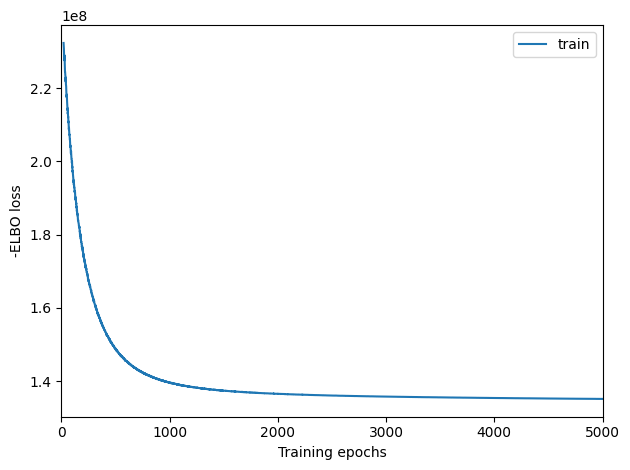

In [11]:
mod_map.plot_history(20)

In [12]:
# --- 3. Process Results and Add to AnnData ---
print("\n--- Processing Deconvolution Results ---")

abundance_key = "q05_cell_abundance_w_sf" # Or check alternatives as before
if abundance_key not in adata_vis_for_deconv.obsm:
    possible_keys = [k for k in adata_vis_for_deconv.obsm.keys() if 'cell_abundance_w_sf' in k]
    if possible_keys: abundance_key = possible_keys[0]; print(f"Using abundance key: '{abundance_key}'")
    else: raise KeyError("Could not find Cell2location abundance results.")

# Get the abundance DataFrame directly
abundance_df = adata_vis_for_deconv.obsm[abundance_key].copy()

# Clean the column names
prefix_to_remove = "q05cell_abundance_w_sf_"
cleaned_column_names = [name.replace(prefix_to_remove, "") for name in abundance_df.columns]
abundance_df.columns = cleaned_column_names
print(f"Cleaned cell type names for plotting: {cleaned_column_names}")

# Align index with the QC'd visium object
abundance_df = abundance_df.loc[adata_vis_qc.obs_names]

# Add abundance scores with cleaned names directly to adata_vis_qc.obs
# Check if columns already exist to prevent duplicates if re-running cells
cols_to_add = abundance_df.columns.difference(adata_vis_qc.obs.columns)
adata_vis_qc.obs = pd.concat([adata_vis_qc.obs, abundance_df[cols_to_add]], axis=1)
print(f"Added {len(cols_to_add)} abundance scores as columns to adata_vis_qc.obs")


# --- 4. Save the Visium AnnData with Results ---
# (Saving code remains the same - uses adata_vis_qc which now has the results in .obs)
results_filename = "visium_data_with_c2l_results_v3_merged.h5ad"
results_save_dir = "./c2l_results_v3/"
os.makedirs(results_save_dir, exist_ok=True)
results_save_path = os.path.join(results_save_dir, results_filename)
print(f"\n--- Saving Visium AnnData with Cell2location results ---")
print(f"Saving object to: {results_save_path}")
try:
    adata_vis_qc.write(results_save_path, compression='gzip')
    print("Successfully saved adata_vis_qc with abundance scores.")
except Exception as e:
    print(f"ERROR saving AnnData with results: {e}")


--- Processing Deconvolution Results ---
Cleaned cell type names for plotting: ['B_Plasma.cells', 'Dendritic.cells', 'Endothelial.cells', 'Epithelial.cells', 'Fibroblasts', 'Macrophages', 'Malignant.cells', 'Mast.cells', 'Myocytes', 'T.cells', 'Potential_RICs']
Added 0 abundance scores as columns to adata_vis_qc.obs

--- Saving Visium AnnData with Cell2location results ---
Saving object to: ./c2l_results_v3/visium_data_with_c2l_results_v3_merged.h5ad
Successfully saved adata_vis_qc with abundance scores.


In [13]:
print("\n--- Visualizing Deconvolution Results ---")
cell_types_to_plot = cleaned_column_names # Use the cleaned names list
unique_samples = adata_vis_qc.obs["sample_id"].unique()
plt.rcParams['figure.figsize'] = (6, 6)
plot_save_dir = "./c2l_plots_v3_sep/"
os.makedirs(plot_save_dir, exist_ok=True)

for sample_id in unique_samples:
        print(f"\nPlotting spatial abundance results for sample: {sample_id}")
        sample_id_str = str(sample_id)
        if sample_id_str not in adata_vis_qc.uns["spatial"]: continue
        adata_sample = adata_vis_qc[adata_vis_qc.obs["sample_id"] == sample_id_str].copy()
        if adata_sample.n_obs == 0: continue

        try:
            # Define filename suffix for squidpy save
            plot_filename_suffix = f"_c2l_abundance_sample_v3_merged{sample_id_str}.png"

            # Plot and save using squidpy's save argument
            sq.pl.spatial_scatter(
                adata_sample,
                library_id=sample_id_str,
                shape=None,
                color=cell_types_to_plot,
                cmap='Reds',
                size=3.5,
                img=True,
                ncols=4,
                vmin=0,
                # We removed show=False and return_fig=True
                # Add save argument here
                save=plot_filename_suffix
            )
            # Note: suptitle cannot be easily added when using sq.pl save directly

            # plt.show() # Usually not needed as sq.pl shows by default unless save is used? Test this.
            # If plots don't show, uncomment plt.show()

            # Clear figure just in case to avoid memory leaks
            plt.clf()
            plt.close('all') # Close all figures from the previous plot call

        except KeyError as e:
           print(f"  KeyError during plotting for sample {sample_id_str}: {e}.")
        except Exception as e:
           print(f"  An error occurred during plotting for sample {sample_id_str}: {e}")
           plt.close('all') # Attempt to close figures even on error


--- Visualizing Deconvolution Results ---

Plotting spatial abundance results for sample: 1

Plotting spatial abundance results for sample: 2

Plotting spatial abundance results for sample: 3

Plotting spatial abundance results for sample: 4

Plotting spatial abundance results for sample: 5

Plotting spatial abundance results for sample: 6

Plotting spatial abundance results for sample: 7

Plotting spatial abundance results for sample: 8



Plotting spatial abundance results for sample: 1
  An error occurred during plotting for sample 1: PathCollection.set() got an unexpected keyword argument 'show'

Plotting spatial abundance results for sample: 2
  An error occurred during plotting for sample 2: PathCollection.set() got an unexpected keyword argument 'show'

Plotting spatial abundance results for sample: 3
  An error occurred during plotting for sample 3: PathCollection.set() got an unexpected keyword argument 'show'

Plotting spatial abundance results for sample: 4
  An error occurred during plotting for sample 4: PathCollection.set() got an unexpected keyword argument 'show'

Plotting spatial abundance results for sample: 5
  An error occurred during plotting for sample 5: PathCollection.set() got an unexpected keyword argument 'show'

Plotting spatial abundance results for sample: 6
  An error occurred during plotting for sample 6: PathCollection.set() got an unexpected keyword argument 'show'

Plotting spatial abun

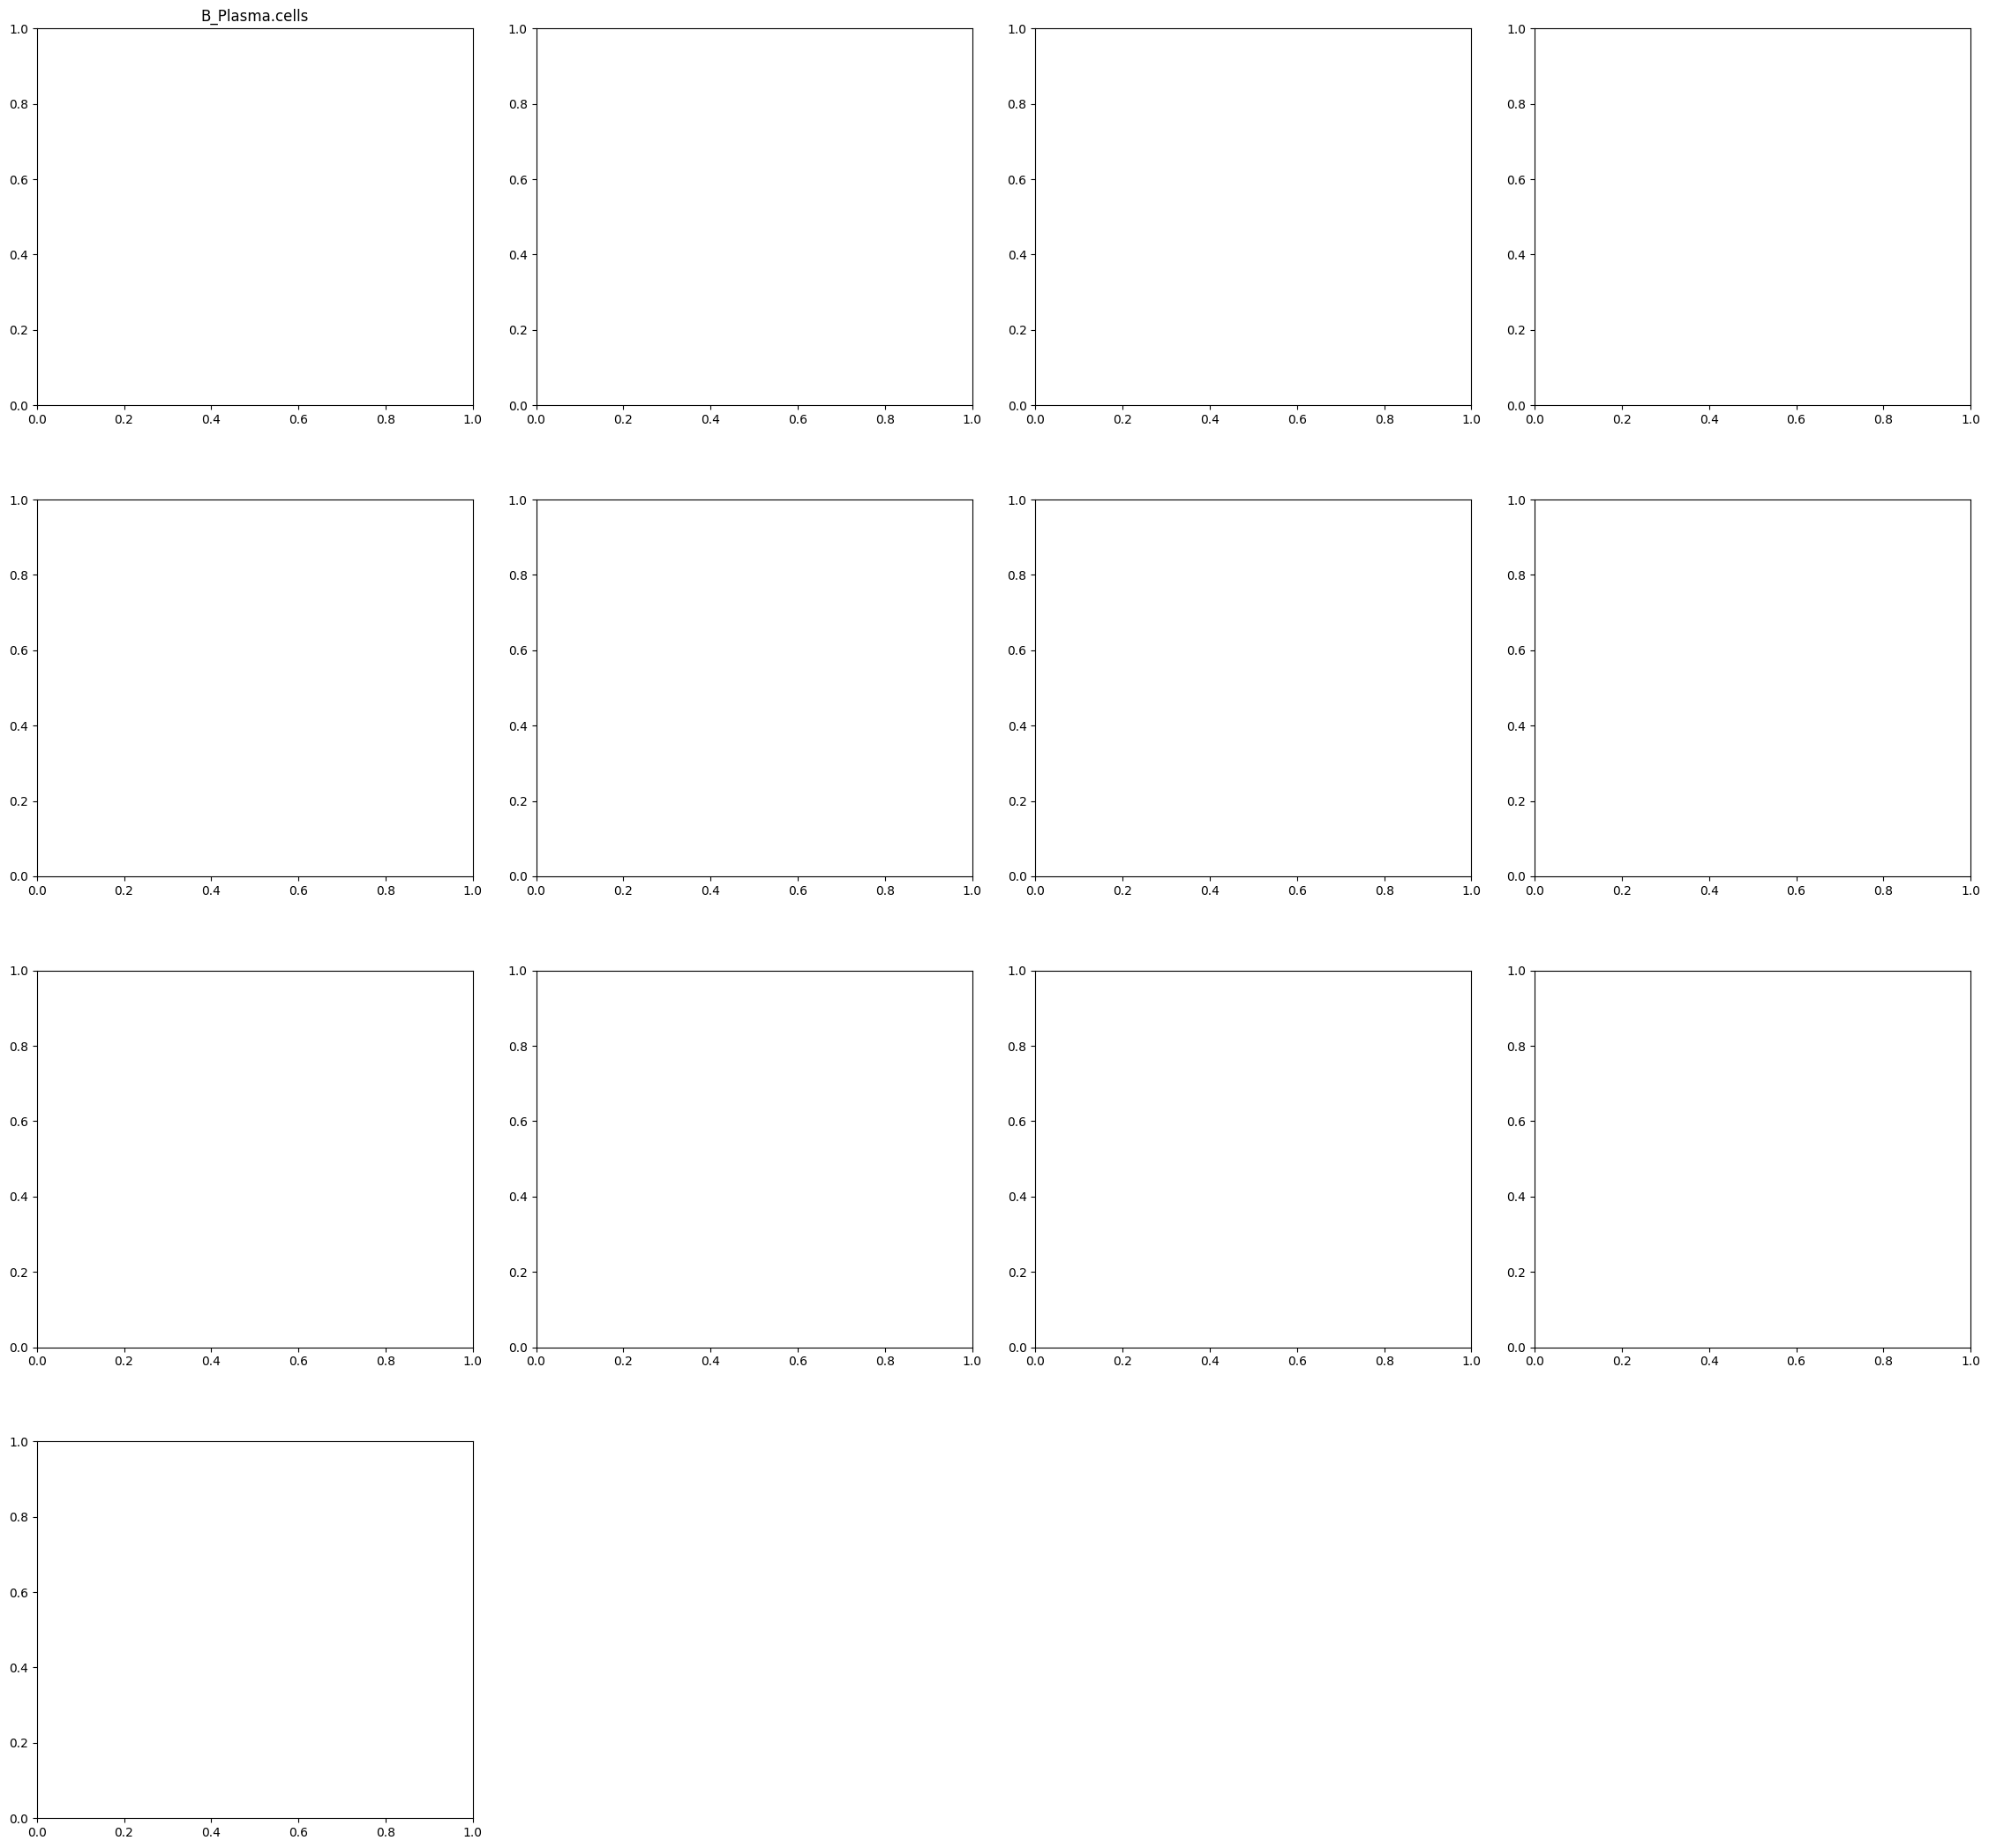

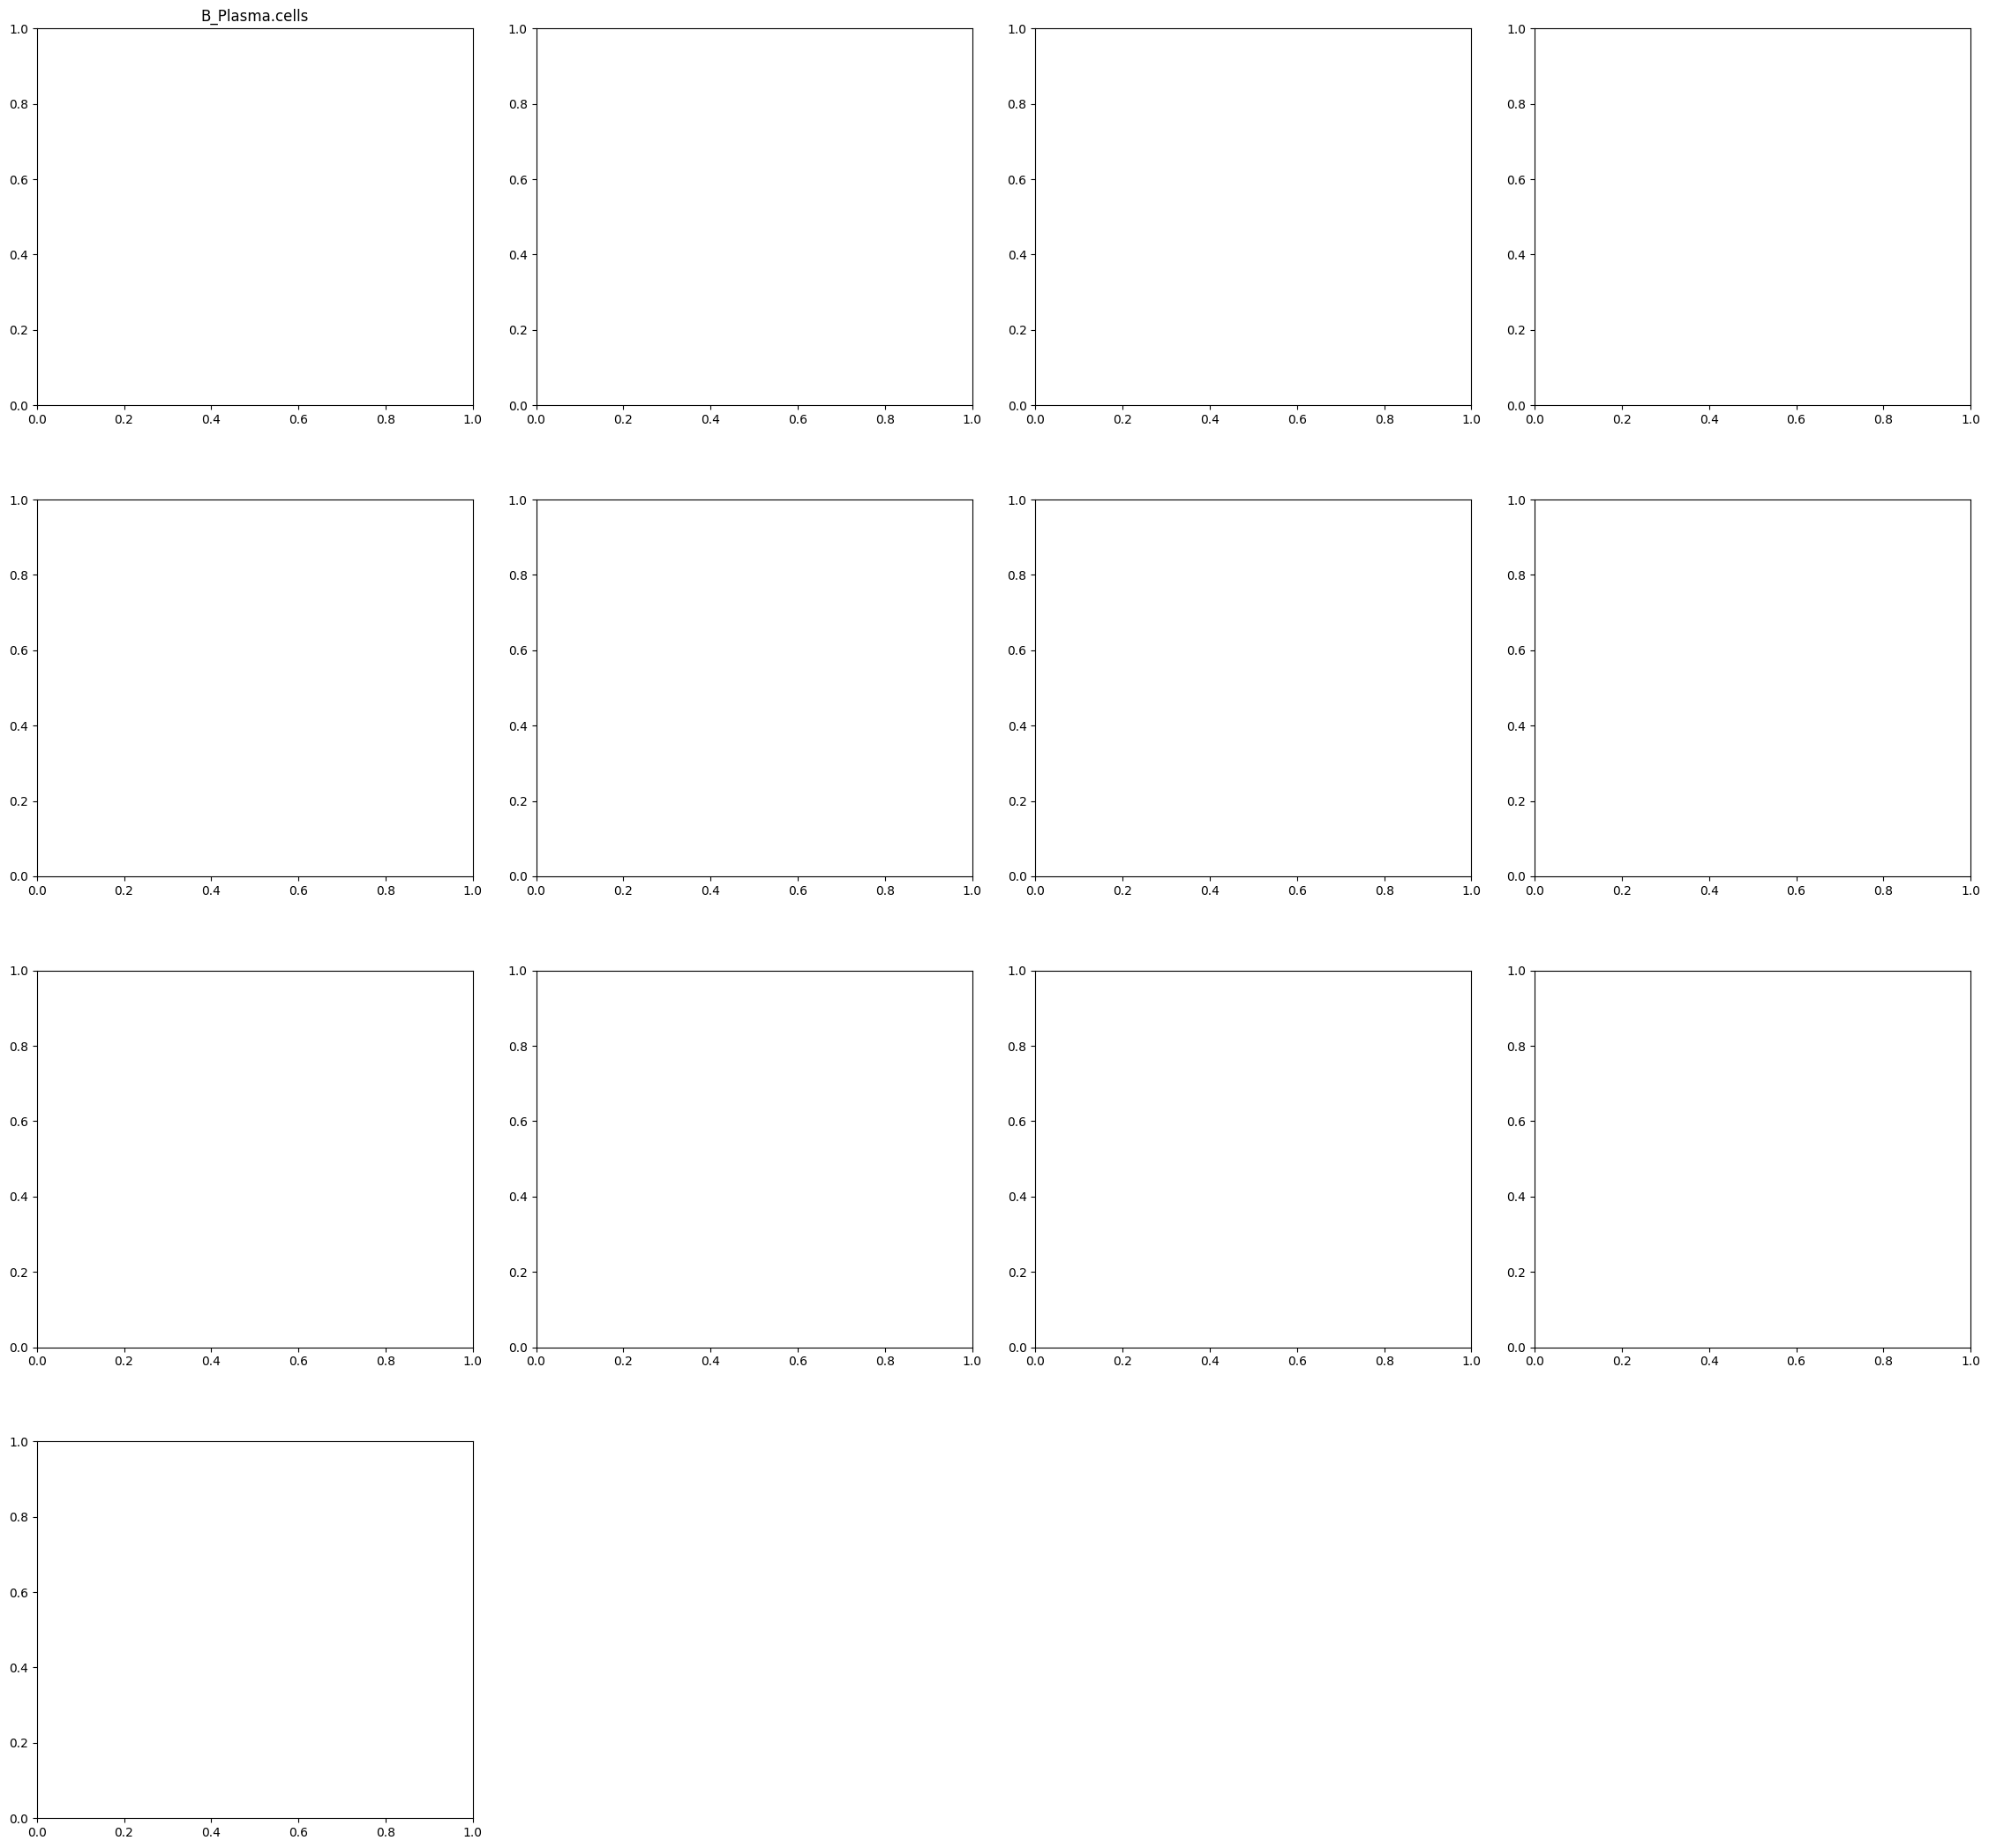

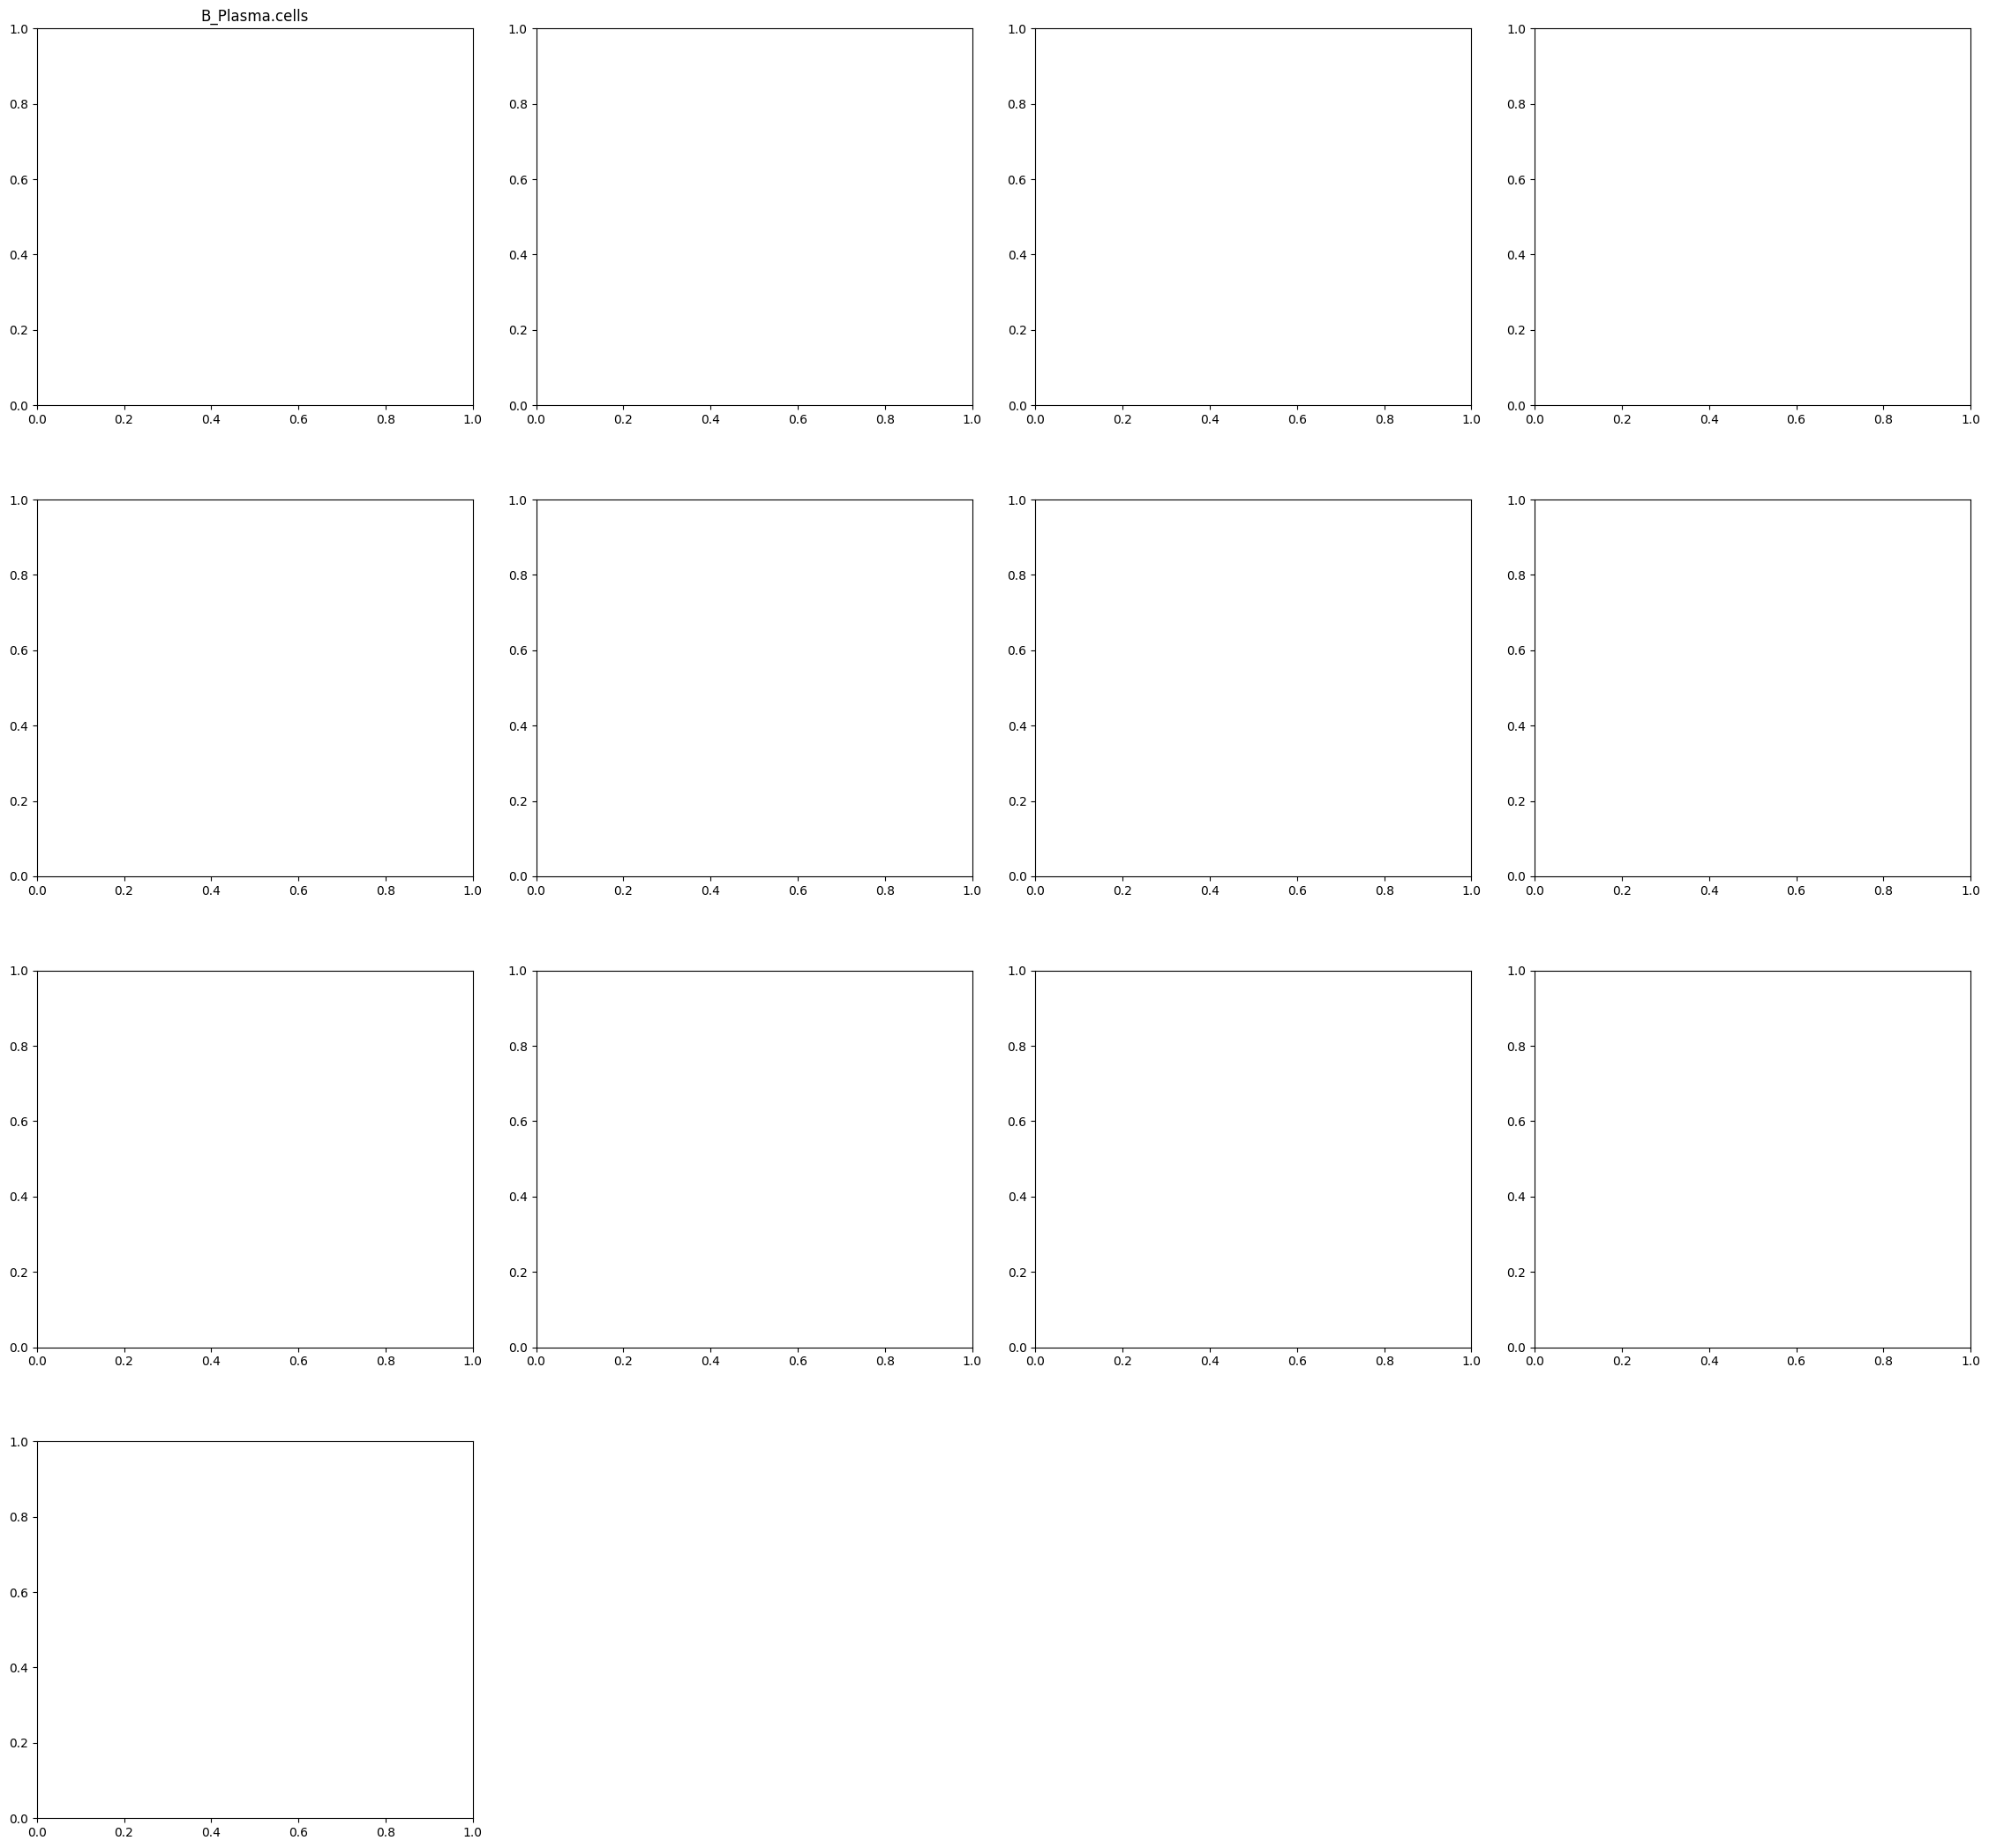

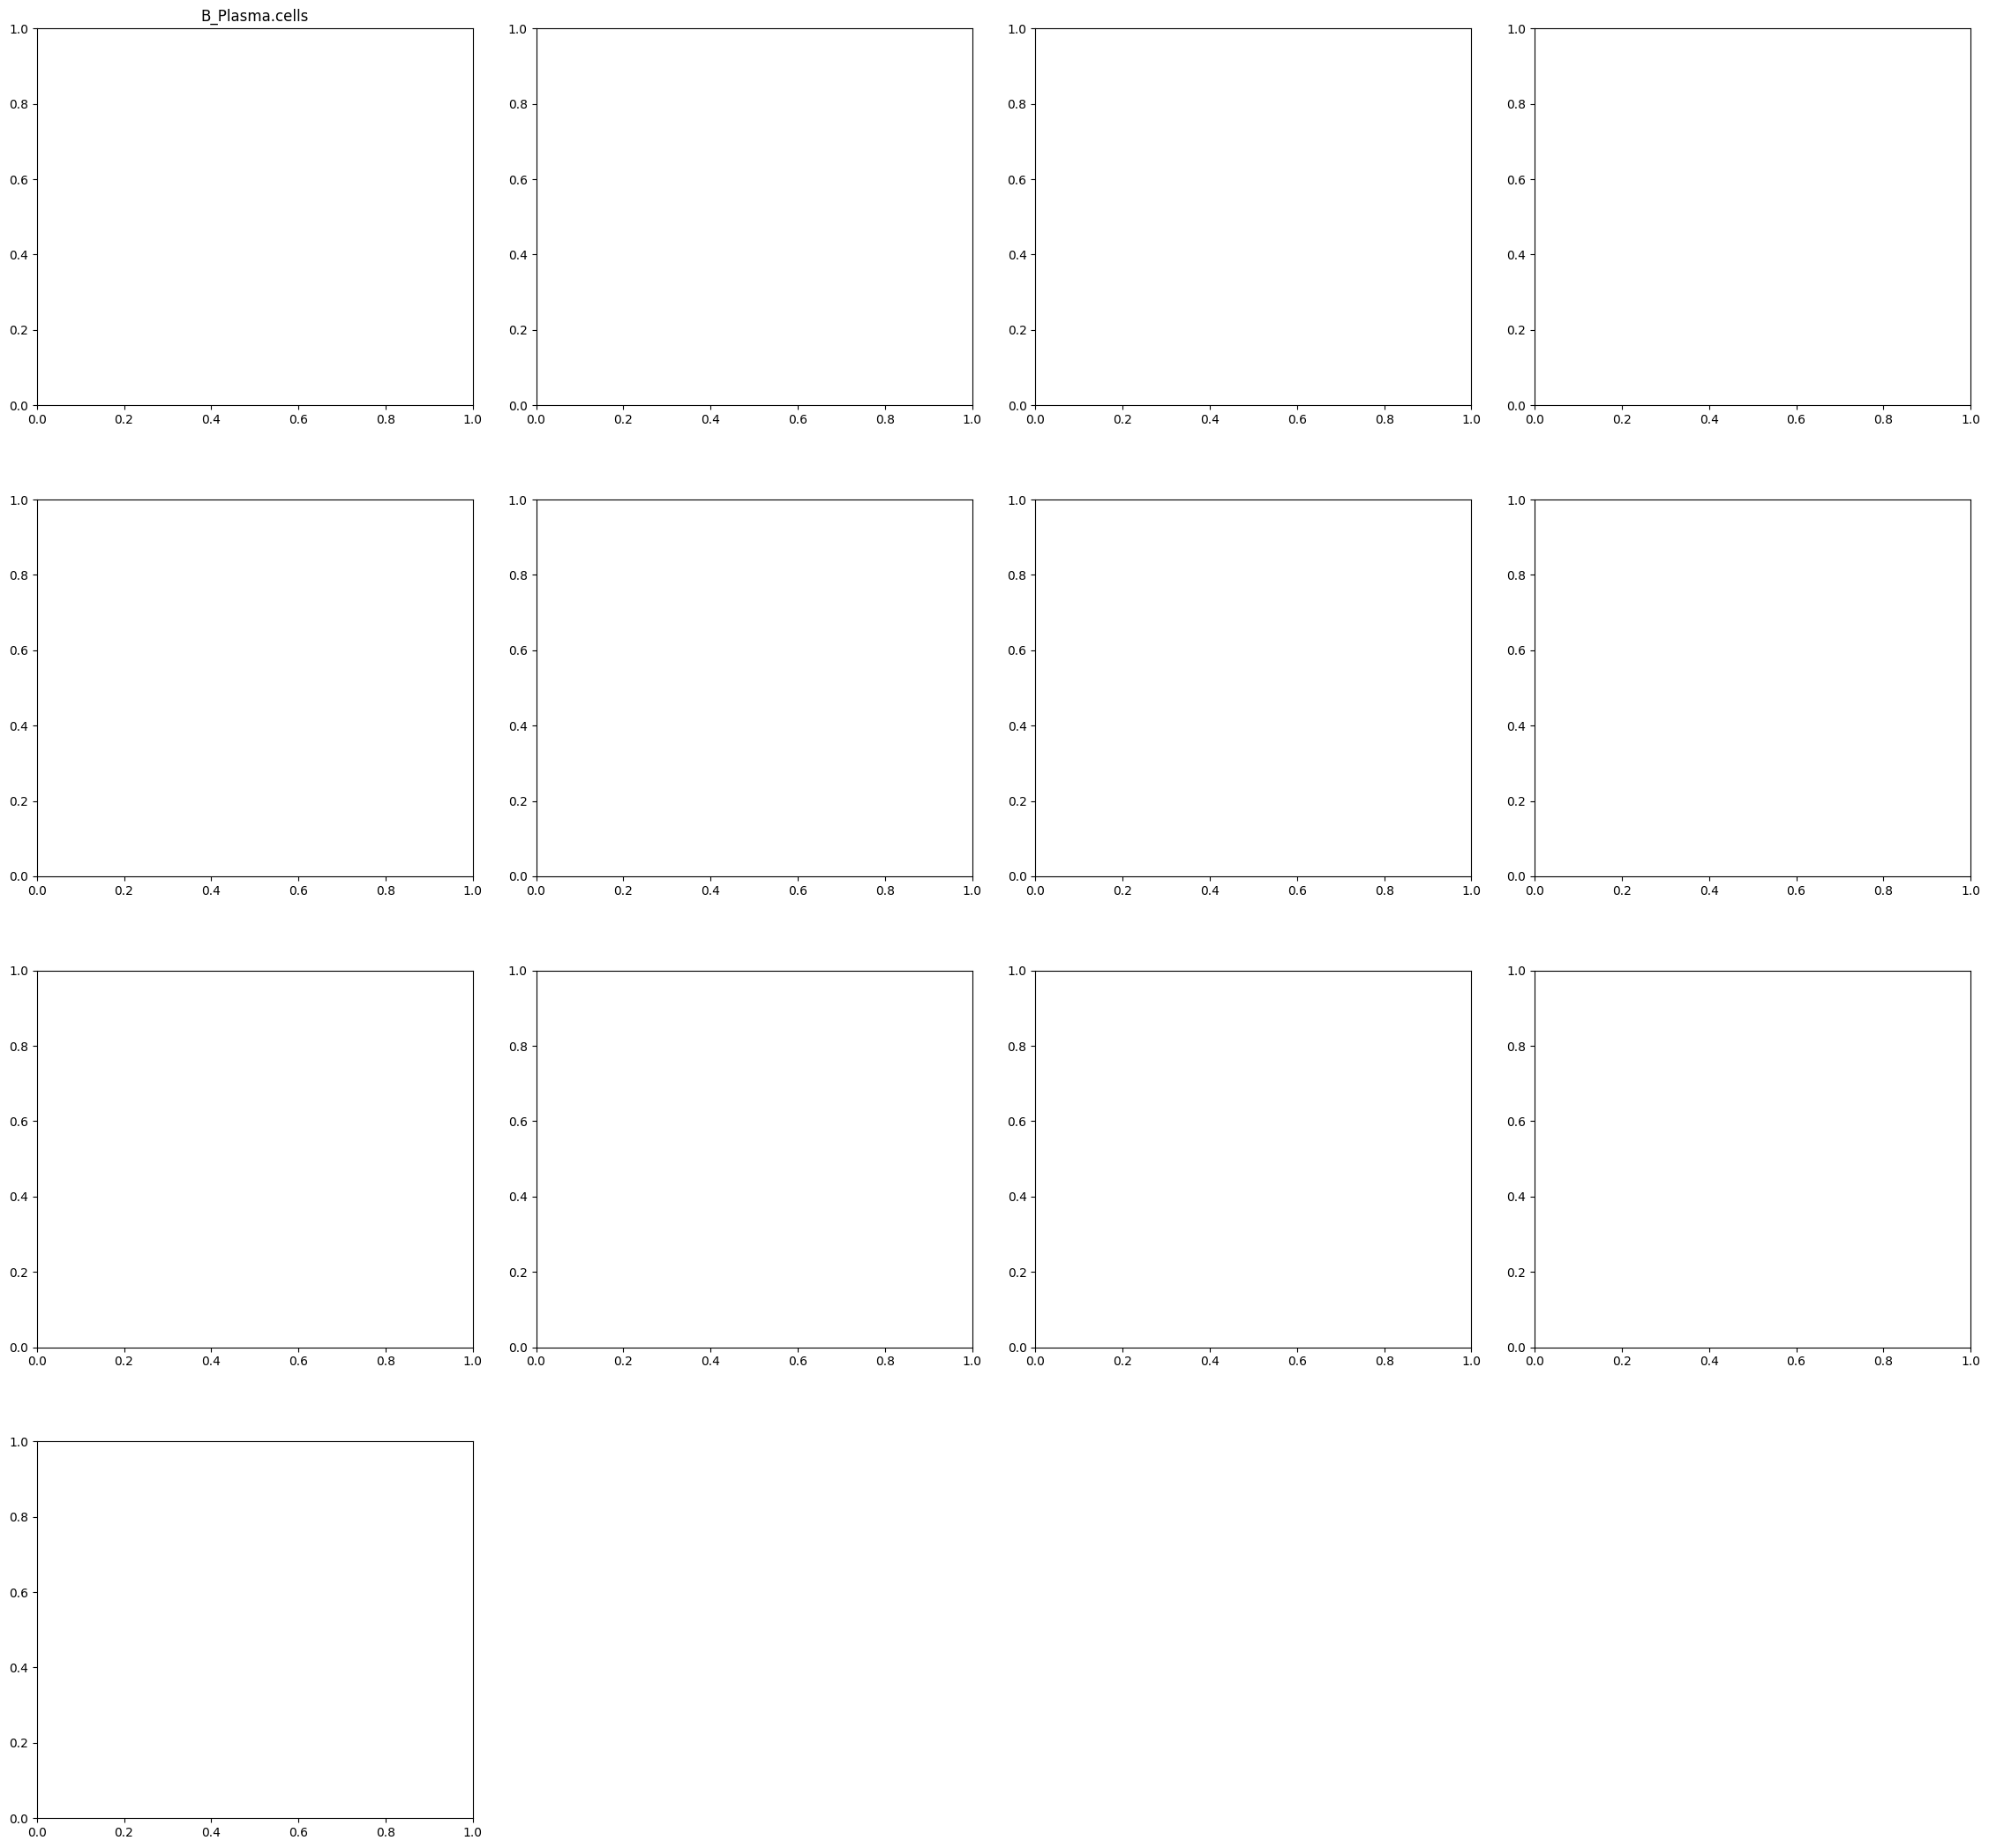

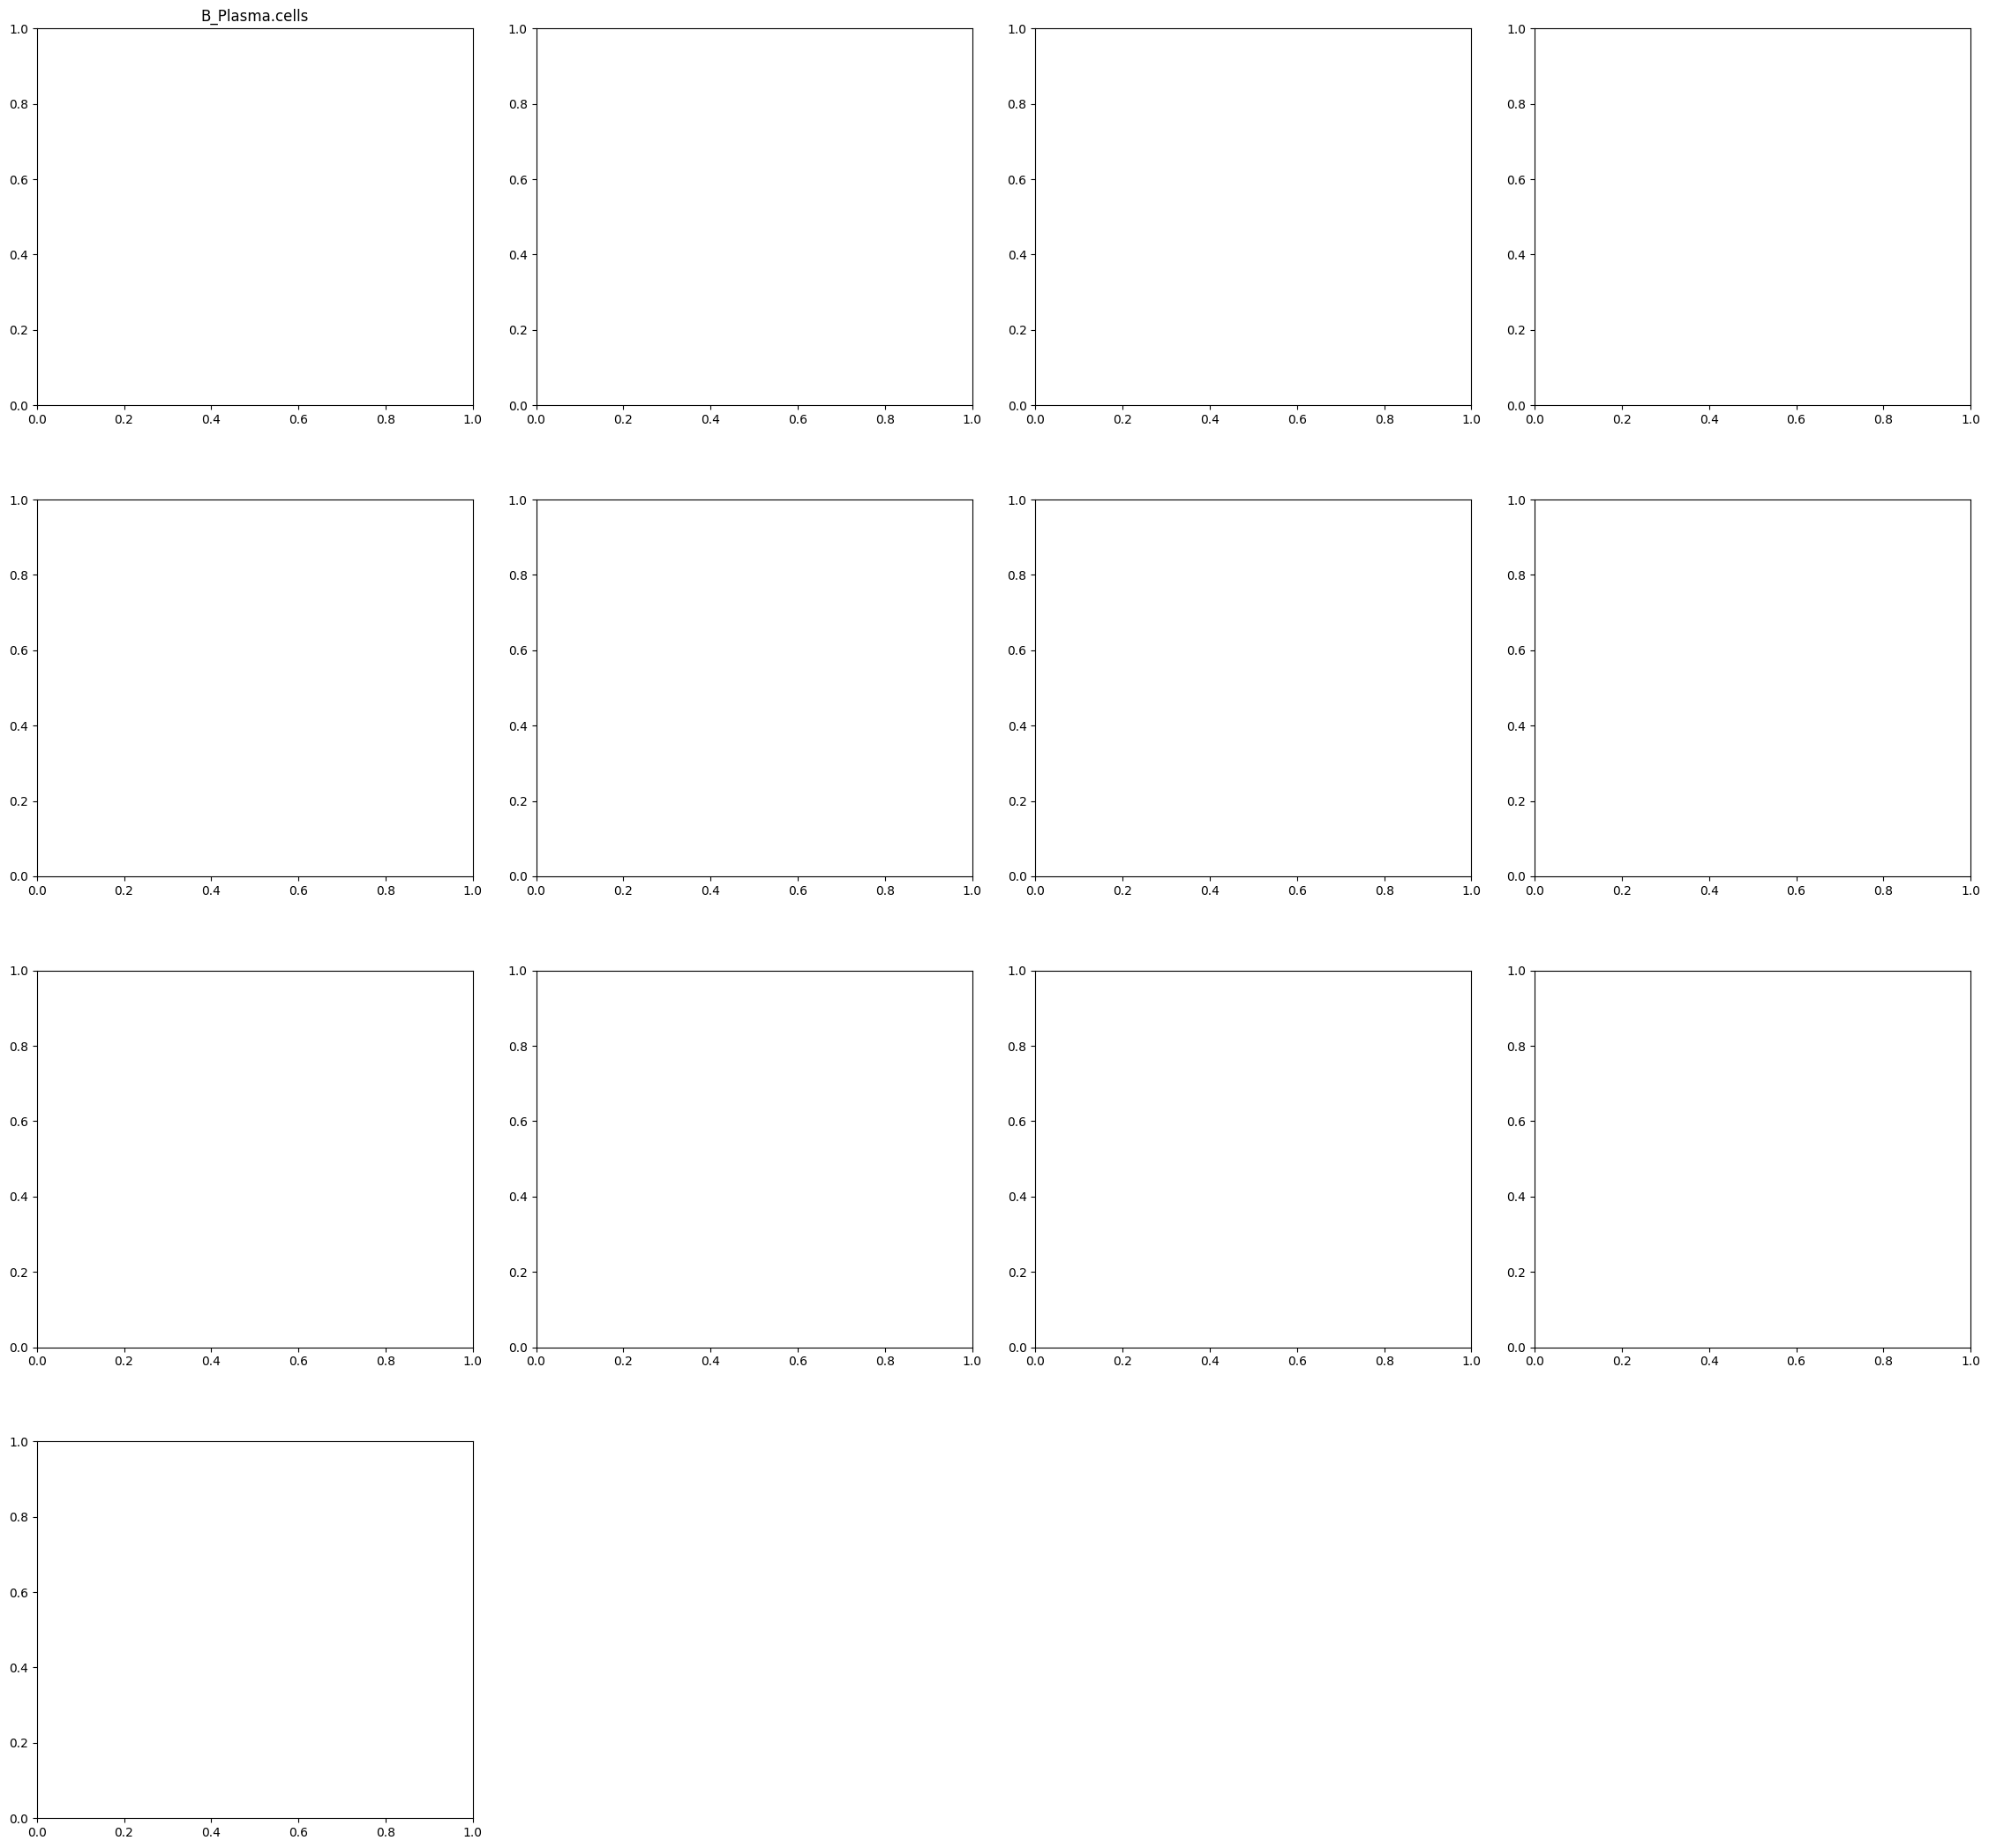

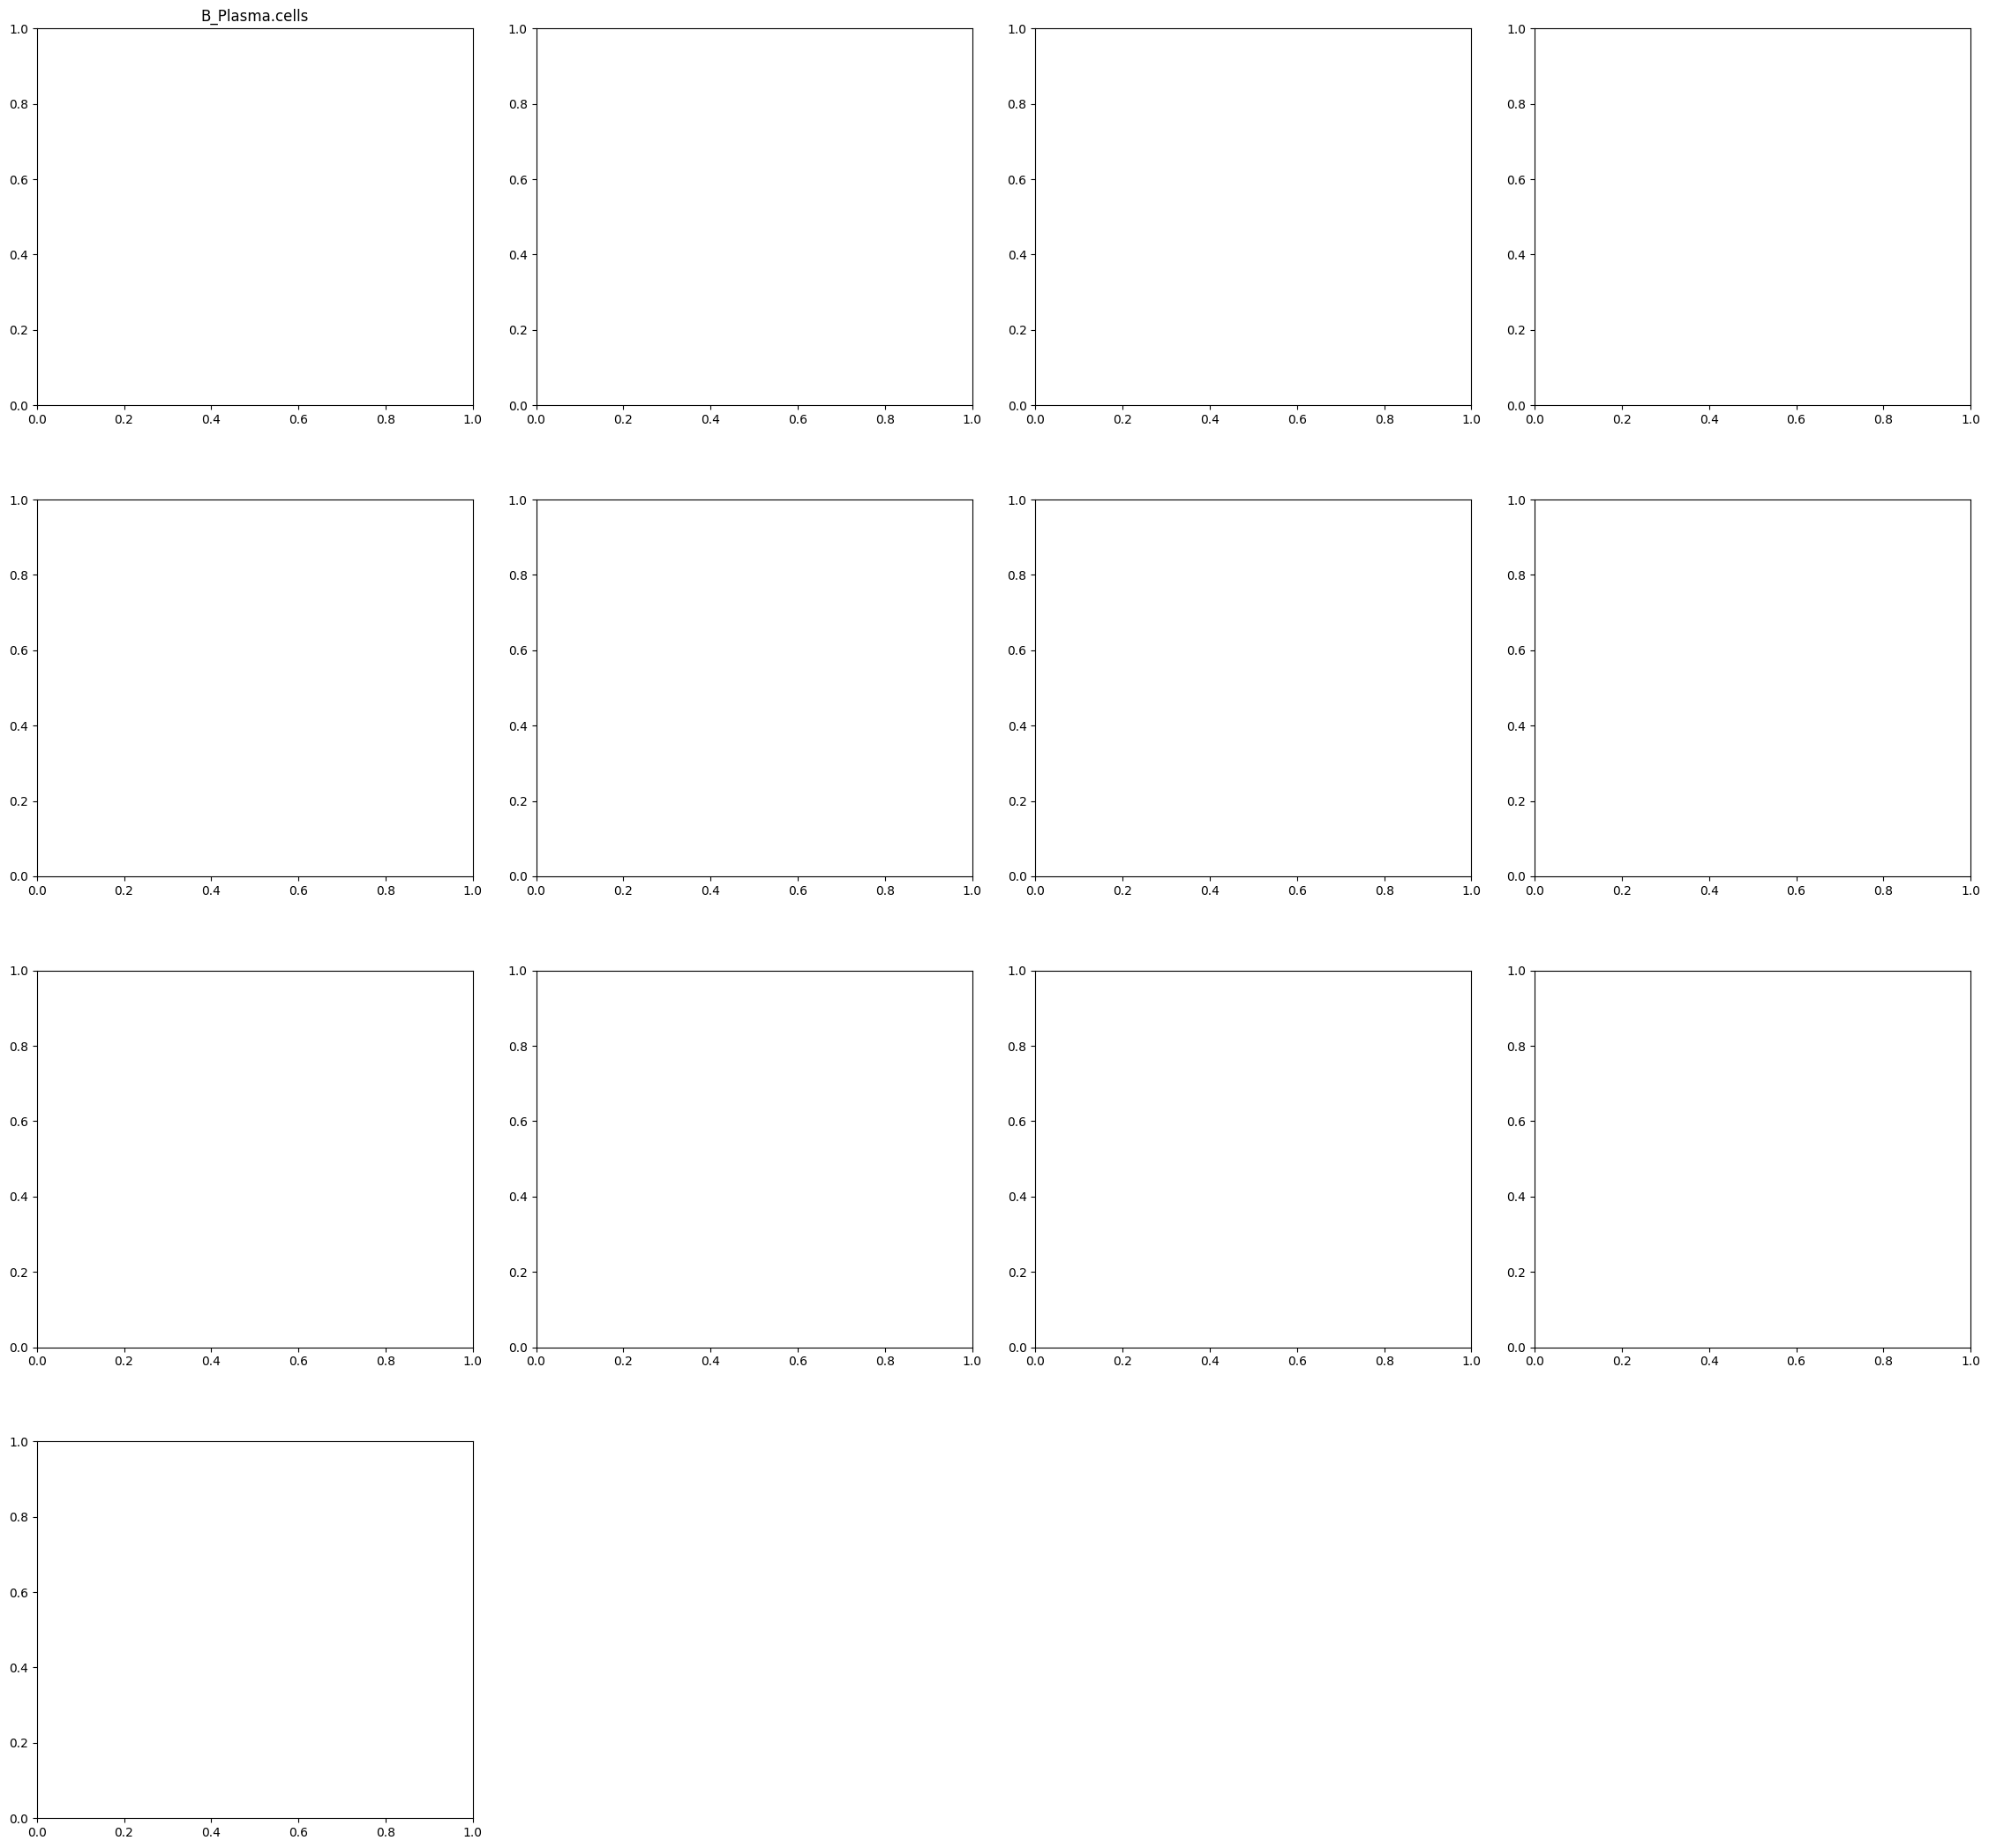

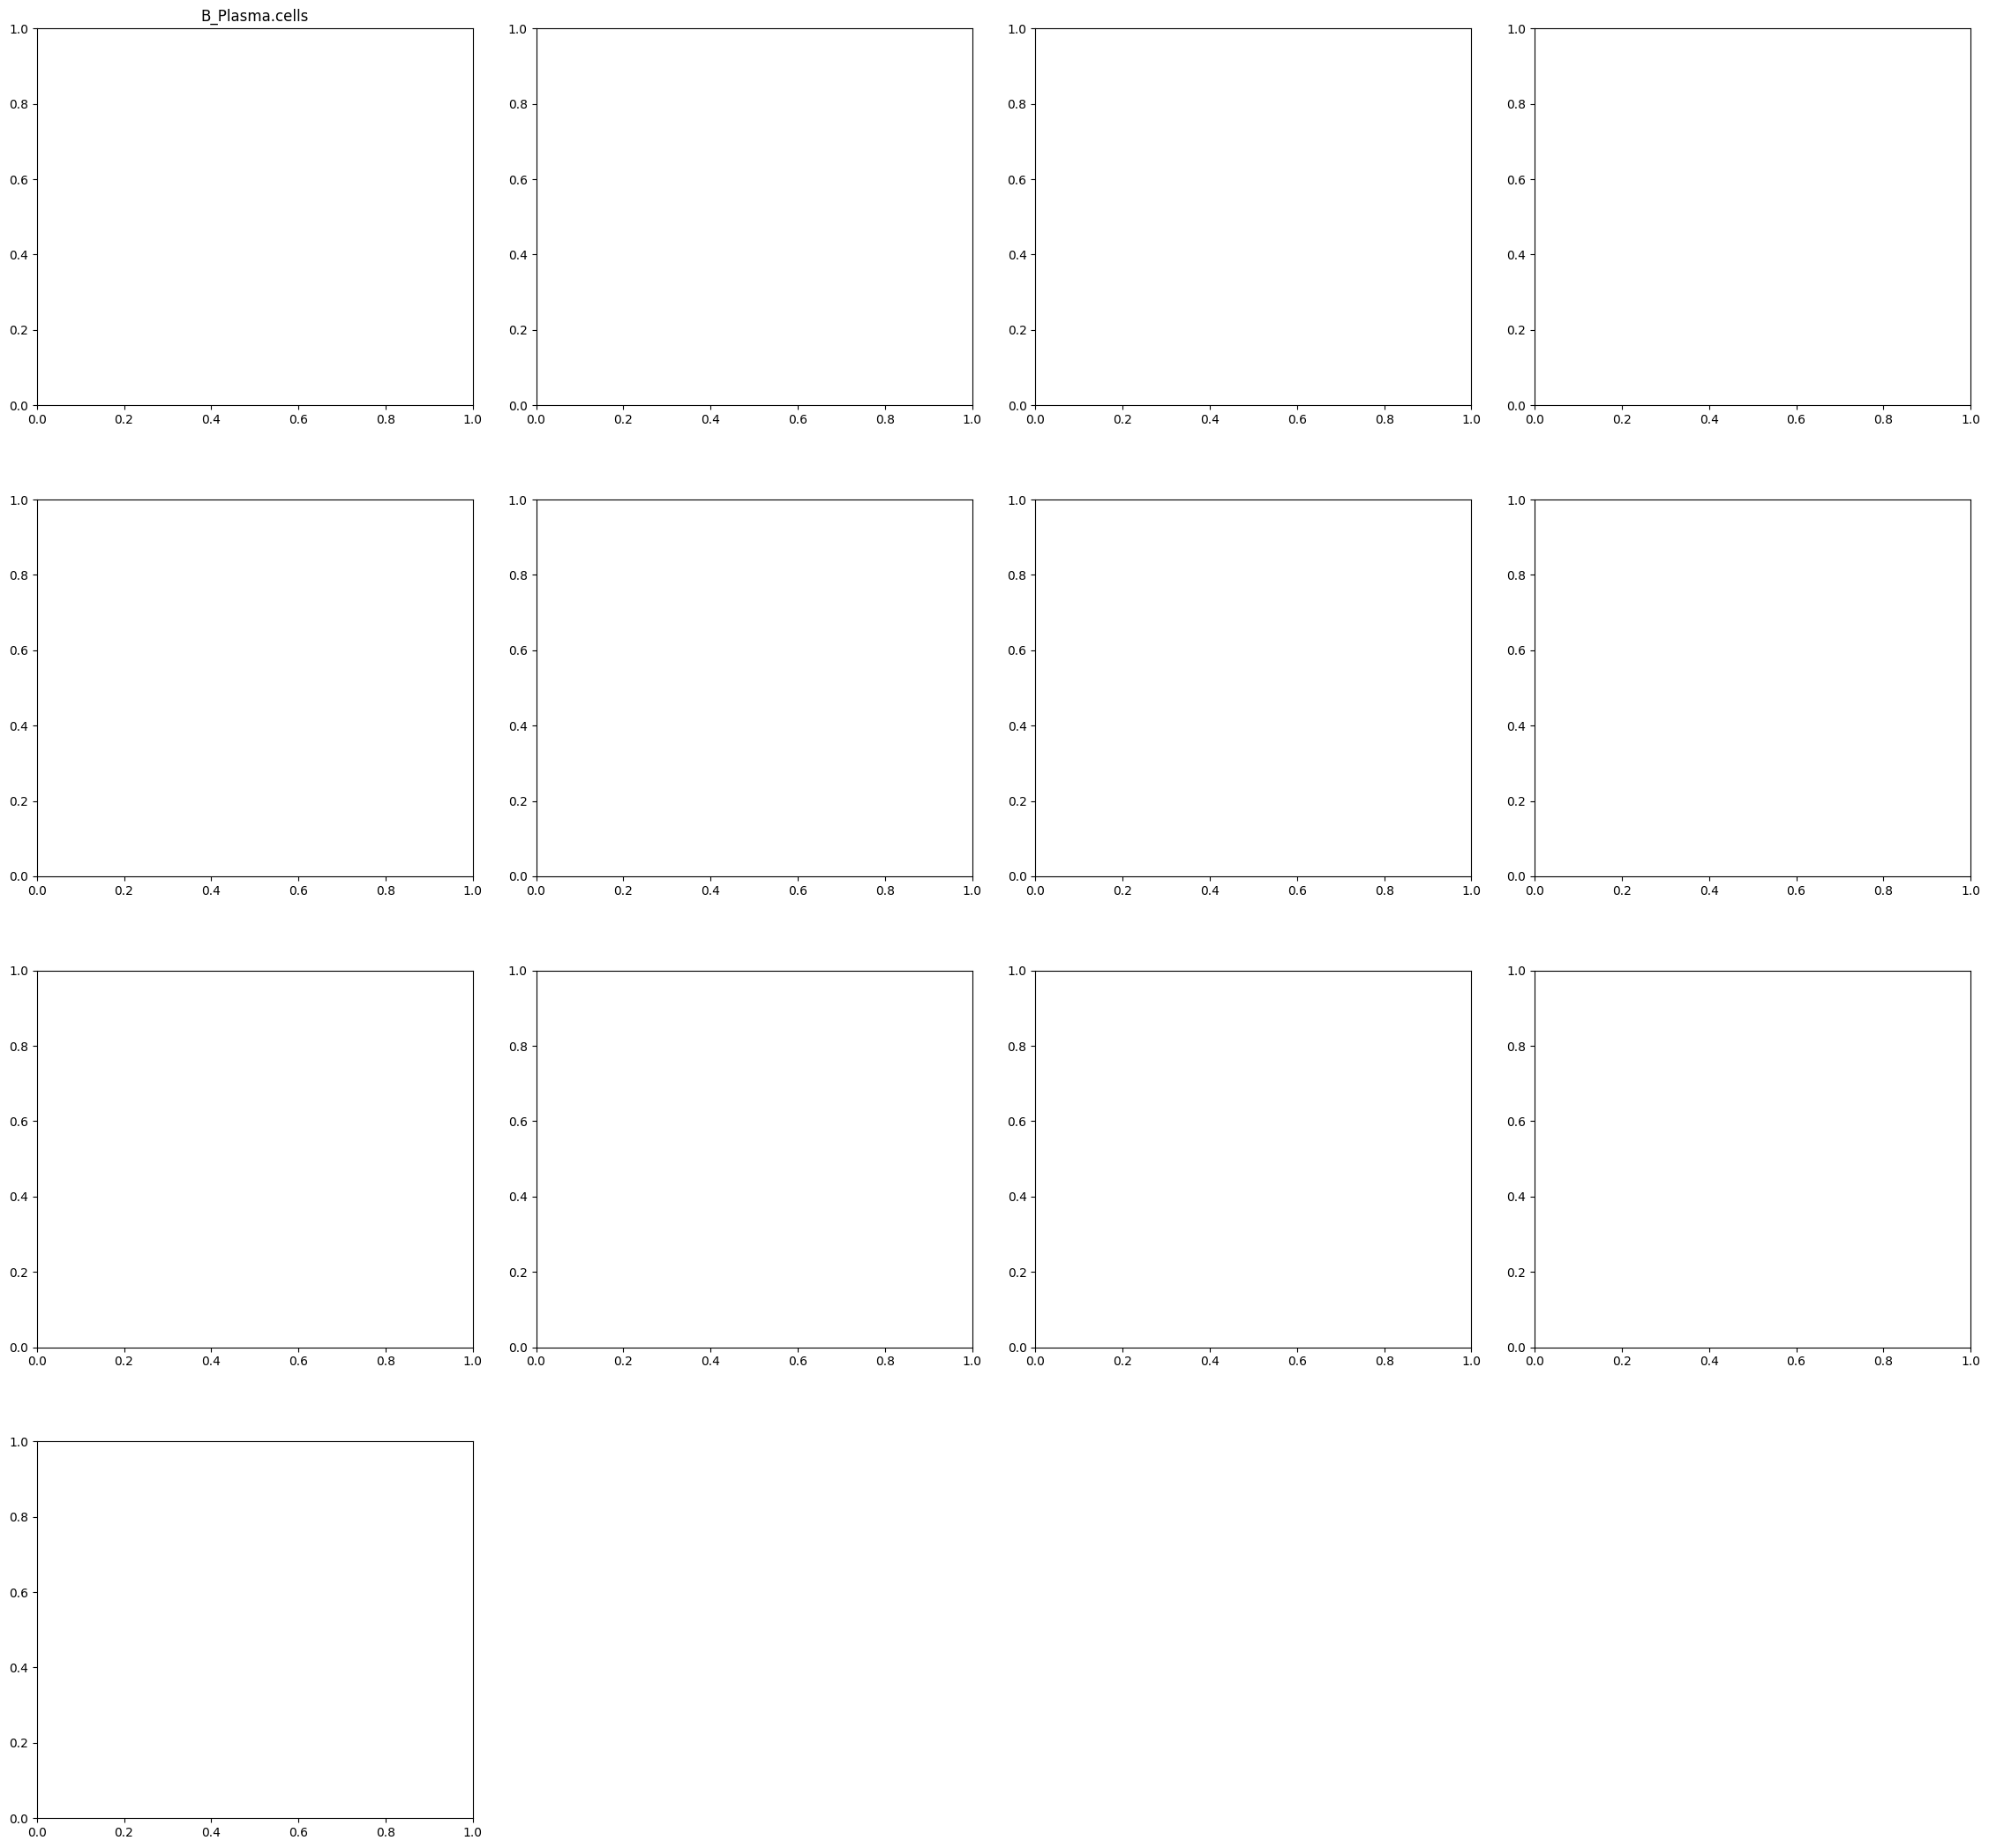

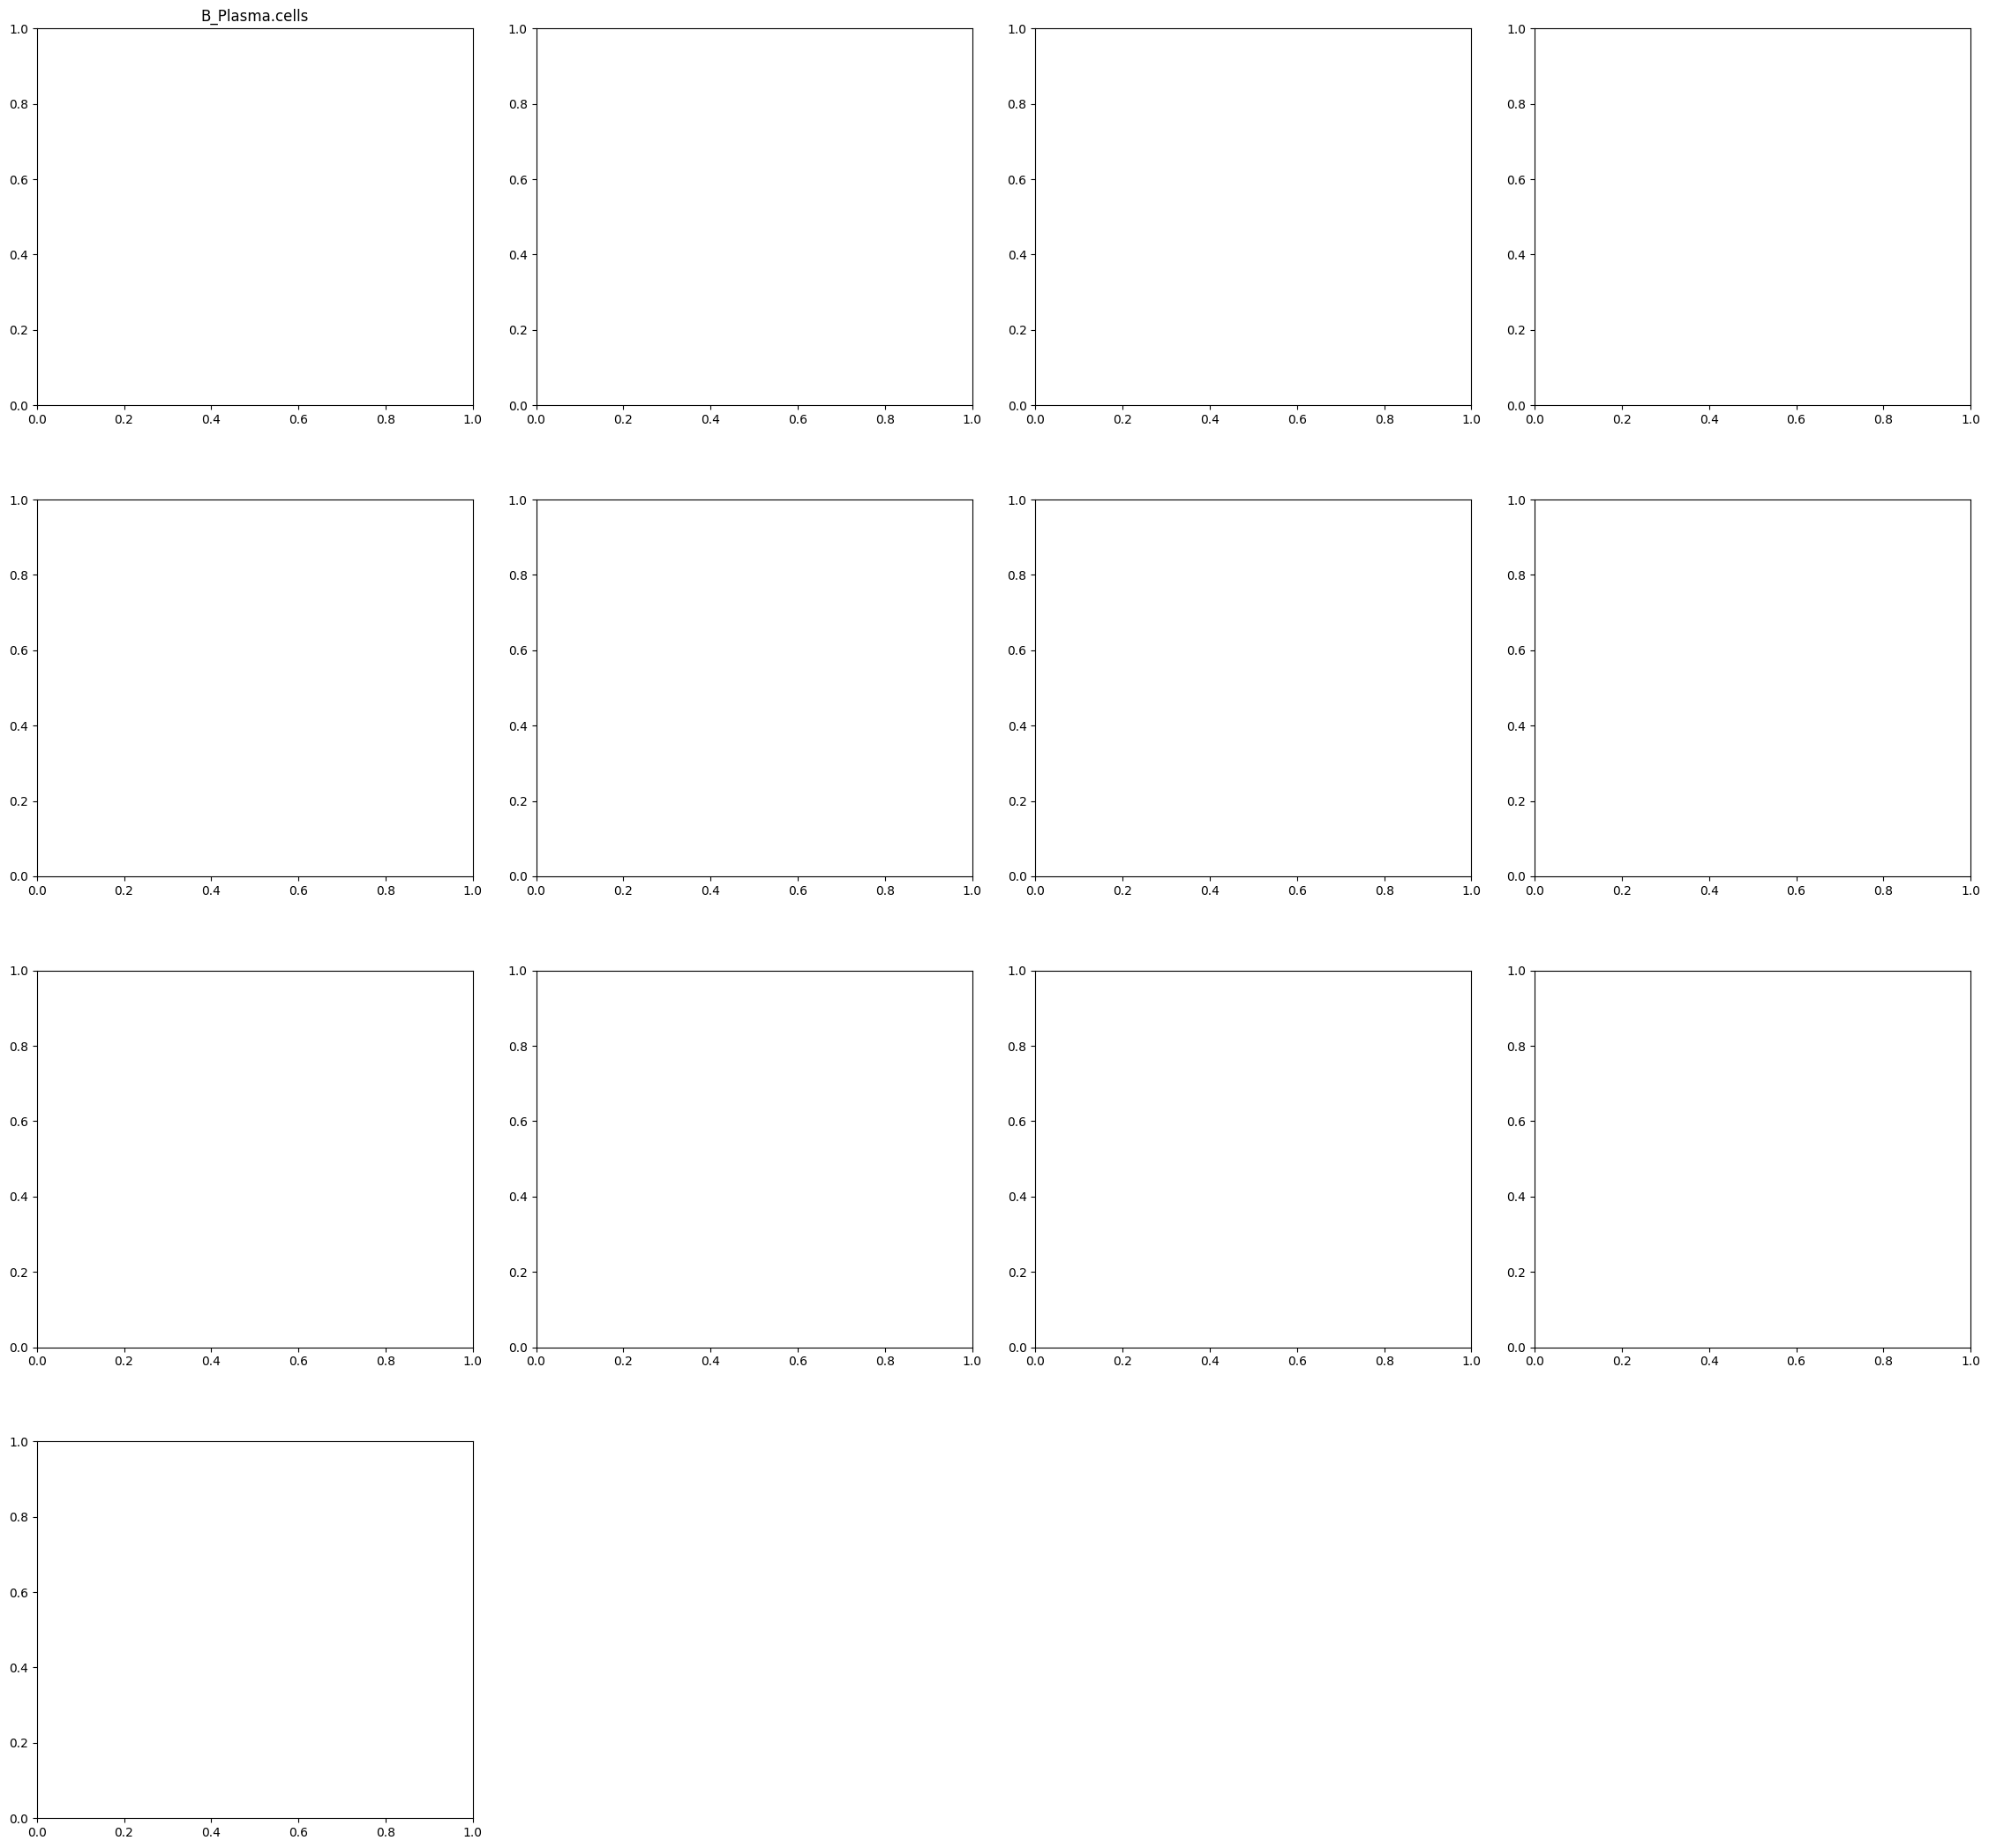

In [14]:

for sample_id in unique_samples:
    print(f"\nPlotting spatial abundance results for sample: {sample_id}")
    sample_id_str = str(sample_id)
    if sample_id_str not in adata_vis_qc.uns["spatial"]: continue
    adata_sample = adata_vis_qc[adata_vis_qc.obs["sample_id"] == sample_id_str].copy()
    if adata_sample.n_obs == 0: continue

    try:
        # Generate the plot object (don't show yet)
        fig = sq.pl.spatial_scatter(
            adata_sample,
            library_id=sample_id_str,
            shape=None,
            color=cell_types_to_plot,
            cmap='Reds',
            size=3.5,
            img=True,
            ncols=4,
            vmin=0,
            show=False, # Important: Prevent immediate display
            return_fig=True # Get the figure object back
        )

        # Add overall title and adjust layout
        fig.suptitle(f"Cell2location Estimated Abundance - Sample {sample_id_str}", y=1.02)
        # fig.tight_layout(rect=[0, 0.03, 1, 0.98]) # tight_layout often done by squidpy

        # --- Save the Figure ---
        plot_filename = f"c2l_abundance_sample_v3_sep{sample_id_str}.png"
        plot_save_path = os.path.join(plot_save_dir, plot_filename)
        print(f"  Saving plot to: {plot_save_path}")
        fig.savefig(plot_save_path, dpi=150, bbox_inches='tight') # Save the figure object
        # -----------------------

        plt.show() # Now display the figure inline

    except KeyError as e:
       print(f"  KeyError during plotting for sample {sample_id_str}: {e}.")
    except Exception as e:
       print(f"  An error occurred during plotting for sample {sample_id_str}: {e}")

print("\n--- Workflow Complete ---")

print(f"Result plots saved in: {plot_save_dir}")

In [ ]:

import matplotlib.pyplot as plt
import squidpy as sq
import pandas as pd
import numpy as np

print("\n--- Visualizing Deconvolution Composition ---")

# --- Option 1: Plot Dominant Cell Type ---
print("\nGenerating plot colored by dominant cell type per spot...")

# Get the abundance data from obs where we added it
abundance_columns = cleaned_column_names # Use the cleaned names
abundance_df = adata_vis_qc.obs[abundance_columns]

# # Find the column name (cell type) with the maximum abundance for each spot
# adata_vis_qc.obs['dominant_cell_type'] = abundance_df.idxmax(axis=1)
# adata_vis_qc.obs['dominant_cell_type'] = pd.Categorical(adata_vis_qc.obs['dominant_cell_type']) # Make categorical

# unique_samples = adata_vis_qc.obs["sample_id"].unique()
# plt.rcParams['figure.figsize'] = (8, 7) # Adjust figure size for single plot

# for sample_id in unique_samples:
#     print(f"  Plotting dominant type for sample: {sample_id}")
#     sample_id_str = str(sample_id)
#     if sample_id_str not in adata_vis_qc.uns["spatial"]: continue

#     adata_sample = adata_vis_qc[adata_vis_qc.obs["sample_id"] == sample_id_str].copy()
#     if adata_sample.n_obs == 0: continue

#     try:
#         # Need a qualitative colormap. Use scanpy's default or specify one.
#         # Get number of categories for legend sizing
#         n_cats = len(adata_sample.obs['dominant_cell_type'].cat.categories)
#         sq.pl.spatial_scatter(
#             adata_sample,
#             library_id=sample_id_str,
#             shape=None,
#             color='dominant_cell_type', # Color by the new column
#             size=1.3,
#             img=True,
#             legend_loc='right margin', # Or 'on data' if space allows
#             legend_fontsize=8 if n_cats < 20 else 6, # Adjust legend font size
#             title=f"Dominant Cell Type (Cell2location) - Sample {sample_id_str}"
#         )
#         plt.show()
#     except Exception as e:
#         print(f"    Error plotting dominant type for sample {sample_id_str}: {e}")


# --- Option 3: Calculate and Plot Average Composition per Sample ---
print("\nCalculating and plotting average cell type composition per sample...")

# Calculate Proportions first (relative abundance within each spot)
# Add a small epsilon to prevent division by zero if a spot has all zeros
spot_total_abundance = abundance_df.sum(axis=1) + 1e-9
proportion_df = abundance_df.div(spot_total_abundance, axis=0)

# Add sample ID to the proportion dataframe for grouping
proportion_df['sample_id'] = adata_vis_qc.obs['sample_id']

# Calculate the mean proportion for each cell type within each sample
average_composition = proportion_df.groupby('sample_id').mean()
print("\nAverage Composition (%):")
print(average_composition.round(3) * 100) # Print as percentage

# Plot as a stacked bar chart
try:
    ax = average_composition.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 7),
        cmap='tab20' # Use a colormap with many distinct colors
    )
    plt.title('Average Cell Type Composition per Sample (Cell2location)')
    plt.xlabel('Sample ID')
    plt.ylabel('Average Proportion')
    # Place legend outside the plot
    plt.legend(title='Cell Type', bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.xticks(rotation=0) # Keep sample IDs horizontal
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
    plt.show()
except Exception as e:
     print(f"Error plotting stacked bar chart: {e}")


print("\n--- Composition visualization complete ---")